Sai Raina
USC ID = 4650068238
Github Username = saitiger


## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [114]:
from sklearn.utils import resample
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import math
import random
import os
import csv
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import re


from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

Get the AReM Data Set

In [115]:
path = '../Data/AReM/'
path

'../Data/AReM/'

### (b) Splitting Data

In [116]:
def split_train_test(root):
    train = []
    test = []
    for dir_root, dirs, files in os.walk(root):
        for f in files:
            if 'pdf' not in f:                
                f_p = os.path.normpath(os.path.join(dir_root, f))
                f_p = f_p.replace("\\", "/")
                if 'bending1' in f_p or 'bending2' in f_p:
                    if 'dataset1.csv' in f_p or 'dataset2.csv' in f_p:
                        test.append(f_p)
                    else:
                        train.append(f_p)
                else:
                    if 'dataset1.csv' in f_p or 'dataset2.csv' in f_p or 'dataset3.csv' in f_p:
                        test.append(f_p)
                    else:
                        train.append(f_p)
    return train, test
    print(len(train),len(test))

In [117]:
train_og=[]
train, test = split_train_test(path)
for i in train:
    train_og.append(i)
combined_df_train = pd.DataFrame()
combined_df_test = pd.DataFrame()

for file_path in train:
    
    df= pd.read_csv(file_path, skiprows=5, header=None, on_bad_lines='skip')    
    combined_df_train = combined_df_train.append(df, ignore_index=True)


for file_path in test:
    df= pd.read_csv(file_path, skiprows=5, header=None, on_bad_lines='skip')
    combined_df_test = combined_df_test.append(df, ignore_index=True)

print(combined_df_test.shape)
print(combined_df_train.shape)
print(combined_df_test)
print(combined_df_train)

(9120, 7)
(33117, 7)
           0      1      2      3     4      5     6
0          0  39.25   0.43  22.75  0.43  33.75  1.30
1        250  39.25   0.43  23.00  0.00  33.00  0.00
2        500  39.25   0.43  23.25  0.43  33.00  0.00
3        750  39.50   0.50  23.00  0.71  33.00  0.00
4       1000  39.50   0.50  24.00  0.00  33.00  0.00
...      ...    ...    ...    ...   ...    ...   ...
9115  118750  36.00   2.45  17.00  5.10  20.50  0.87
9116  119000  34.33   1.89  15.00  2.45  17.00  2.12
9117  119250  33.00   7.35  14.60  3.14  13.00  5.70
9118  119500  31.67   1.25  11.00  6.16  19.25  2.17
9119  119750  30.75  10.21  11.75  1.09  18.50  3.20

[9120 rows x 7 columns]
            0      1     2      3     4      5     6
0           0  42.00  0.71  21.25  0.43  30.00  0.00
1         250  41.50  0.50  20.25  1.48  31.25  1.09
2         500  41.50  0.50  14.25  1.92  33.00  0.00
3         750  40.75  0.83  15.75  0.43  33.00  0.00
4        1000  40.00  0.71  20.00  2.74  32.75  0.43


In [118]:

train.extend(test)

data=train
print(len(train),len(train_og))
# data

88 69


In [119]:
Col_Names = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
Original_Names = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
Stats = ['mean', 'std', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']
Order_Stats = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
sniffer = csv.Sniffer()

### (c) Feature Extraction

In [120]:
def label1(file_path):
    return os.path.basename(os.path.dirname(file_path))  

In [121]:
def separator1(file):
    f = open(file)    
    return sniffer.sniff(f.read()).delimiter  

In [122]:
def columns1(segs=1):
    end = 6 * segs + 1
    feature = []
    for i in range(1, end):
        for stat in Stats:
            feature.append(f'{stat}{i}')
#     print(feature)
    return feature

In [123]:
def load_data(files, feature, segs=1, standard=False):
#     print(segs)
    instances  = []
    labels = []
    for f in files:
        
        labels.append(label1(f))
        separator = separator1(f)        
        if separator == ",":
            fd = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')

        else:
             fd = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')            
        fd.columns = Original_Names
        seg_length = int(fd.shape[0] / segs)
        description = []
        for i in range(segs):
            start1 = i * seg_length
            end1 = min((i + 1) * seg_length, fd.shape[0])
            cur_seg = fd[start1 : end1]
            time_col = "# Columns: time"
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            description.append(cur_describe.values.flatten())
        instances.append(np.concatenate(description))
            
  
    feature_frame = pd.DataFrame(instances)
    feature_frame.columns = columns1(segs)
    feature_frame = feature_frame.loc[:, feature]
    feature_frame['label'] = pd.Series(labels)
    return feature_frame


 


In [124]:
def get_actual_ordered_cols():
    feature = []
    for i in range(1, 7):
        for stat in Order_Stats:
            feature.append(f'{stat}{i}')
#             
    return feature
    


In [125]:
feature = get_actual_ordered_cols()


In [126]:
data= load_data(data, feature)
data

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   35.00  47.40  43.954500   44.330  1.558835          43.00        45.0000   
1   33.00  47.75  42.179812   43.500  3.670666          39.15        45.0000   
2   33.00  45.75  41.678063   41.750  2.243490          41.33        42.7500   
3   37.00  48.00  43.454958   43.250  1.386098          42.50        45.0000   
4   36.25  48.00  43.969125   44.500  1.618364          43.31        44.6700   
..    ...    ...        ...      ...       ...            ...            ...   
83  35.50  46.25  43.174938   43.670  1.989052          42.50        44.5000   
84  32.75  47.00  42.760562   44.500  3.398919          41.33        45.3725   
85  19.33  43.50  34.227771   35.500  4.889576          30.50        37.7500   
86  12.50  45.00  33.509729   34.125  4.850923          30.50        36.7500   
87  15.00  46.75  34.660583   35.000  5.315110          31.00        38.2500   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6  max6  \
0    0.0   1.70  0.426250  ...        35.3625         36.500   0.0  1.79   
1    0.0   3.00  0.696042  ...        30.4575         36.330   0.0  2.18   
2    0.0   2.83  0.535979  ...        28.4575         31.250   0.0  1.79   
3    0.0   1.58  0.378083  ...        22.2500         24.000   0.0  5.26   
4    0.0   1.50  0.413125  ...        20.5000         23.750   0.0  2.96   
..   ...    ...       ...  ...            ...            ...   ...   ...   
83   0.0   2.12  0.506583  ...        12.7500         16.500   0.0  5.72   
84   0.0   3.34  0.486167  ...        13.0000         18.565   0.0  5.73   
85   0.0  14.50  3.995729  ...        14.7500         18.670   0.0  9.74   
86   0.0  13.05  4.450771  ...        14.6275         18.750   0.0  8.96   
87   0.0  13.44  4.200896  ...        14.2500         18.500   0.0  8.99   

       mean6  median6      std6  1st_quartile6  3rd_quartile6     label  
0   0.493292    0.430  0.513506          0.000          0.940  bending1  
1   0.613521    0.500  0.524317          0.000          1.000  bending1  
2   0.383292    0.430  0.389164          0.000          0.500  bending1  
3   0.679646    0.500  0.622534          0.430          0.870  bending1  
4   0.555312    0.490  0.487826          0.000          0.830  bending1  
..       ...      ...       ...            ...            ...       ...  
83  0.911979    0.830  0.666161          0.470          1.220  standing  
84  0.842271    0.710  0.722165          0.430          1.090  standing  
85  3.394125    3.100  1.792090          2.105          4.425   walking  
86  3.378479    3.085  1.787360          2.060          4.440   walking  
87  3.244396    3.000  1.630983          2.120          4.240   walking  

[88 rows x 43 columns]

In [127]:
data.describe().loc['std']
data

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   35.00  47.40  43.954500   44.330  1.558835          43.00        45.0000   
1   33.00  47.75  42.179812   43.500  3.670666          39.15        45.0000   
2   33.00  45.75  41.678063   41.750  2.243490          41.33        42.7500   
3   37.00  48.00  43.454958   43.250  1.386098          42.50        45.0000   
4   36.25  48.00  43.969125   44.500  1.618364          43.31        44.6700   
..    ...    ...        ...      ...       ...            ...            ...   
83  35.50  46.25  43.174938   43.670  1.989052          42.50        44.5000   
84  32.75  47.00  42.760562   44.500  3.398919          41.33        45.3725   
85  19.33  43.50  34.227771   35.500  4.889576          30.50        37.7500   
86  12.50  45.00  33.509729   34.125  4.850923          30.50        36.7500   
87  15.00  46.75  34.660583   35.000  5.315110          31.00        38.2500   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6  max6  \
0    0.0   1.70  0.426250  ...        35.3625         36.500   0.0  1.79   
1    0.0   3.00  0.696042  ...        30.4575         36.330   0.0  2.18   
2    0.0   2.83  0.535979  ...        28.4575         31.250   0.0  1.79   
3    0.0   1.58  0.378083  ...        22.2500         24.000   0.0  5.26   
4    0.0   1.50  0.413125  ...        20.5000         23.750   0.0  2.96   
..   ...    ...       ...  ...            ...            ...   ...   ...   
83   0.0   2.12  0.506583  ...        12.7500         16.500   0.0  5.72   
84   0.0   3.34  0.486167  ...        13.0000         18.565   0.0  5.73   
85   0.0  14.50  3.995729  ...        14.7500         18.670   0.0  9.74   
86   0.0  13.05  4.450771  ...        14.6275         18.750   0.0  8.96   
87   0.0  13.44  4.200896  ...        14.2500         18.500   0.0  8.99   

       mean6  median6      std6  1st_quartile6  3rd_quartile6     label  
0   0.493292    0.430  0.513506          0.000          0.940  bending1  
1   0.613521    0.500  0.524317          0.000          1.000  bending1  
2   0.383292    0.430  0.389164          0.000          0.500  bending1  
3   0.679646    0.500  0.622534          0.430          0.870  bending1  
4   0.555312    0.490  0.487826          0.000          0.830  bending1  
..       ...      ...       ...            ...            ...       ...  
83  0.911979    0.830  0.666161          0.470          1.220  standing  
84  0.842271    0.710  0.722165          0.430          1.090  standing  
85  3.394125    3.100  1.792090          2.105          4.425   walking  
86  3.378479    3.085  1.787360          2.060          4.440   walking  
87  3.244396    3.000  1.630983          2.120          4.240   walking  

[88 rows x 43 columns]

In [128]:
import pandas as pd
import numpy as np

def bootstrap_std(data, num_samples=1000):

    std_samples = {col: [] for col in data.columns}

    for _ in range(num_samples):
        sample = data.sample(len(data), replace=True)
        for col in data.columns:
            std_samples[col].append(sample[col].std())

    return std_samples

def compute_confidence_interval(data, alpha=0.1):
  
    intervals = {}
    lower_quantile = alpha / 2
    upper_quantile = 1 - alpha / 2

    for col, values in data.items():
        intervals[col] = (np.percentile(values, 100 * lower_quantile), 
                          np.percentile(values, 100 * upper_quantile))

    return intervals

data1 = data.iloc[:, :-1]

bootstrap_samples = bootstrap_std(data1)
confidence_intervals = compute_confidence_interval(bootstrap_samples)

print("\n90% Confidence Intervals for standard deviation of each feature:")
features = []
lower_bounds = []
upper_bounds = []

for feature, (lower, upper) in confidence_intervals.items():
    features.append(feature)
    lower_bounds.append(lower)
    upper_bounds.append(upper)

results_df = pd.DataFrame({
    'Feature': features,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
})

results_df



90% Confidence Intervals for standard deviation of each feature:


Feature  Lower Bound  Upper Bound
0            min1     8.269736    10.831675
1            max1     3.342710     5.297073
2           mean1     4.728896     5.877548
3         median1     4.814599     5.976319
4            std1     1.588383     1.944904
5   1st_quartile1     5.604059     6.612155
6   3rd_quartile1     4.394047     5.836770
7            min2     0.000000     0.000000
8            max2     4.612211     5.407497
9           mean2     1.391001     1.703043
10        median2     1.232353     1.542896
11           std2     0.801399     0.940390
12  1st_quartile2     0.825518     1.034726
13  3rd_quartile2     1.882937     2.294378
14           min3     2.747301     3.103646
15           max3     4.263340     5.507464
16          mean3     3.456439     4.500849
17        median3     3.484977     4.539202
18           std3     0.763704     1.121880
19  1st_quartile3     3.662565     4.693761
20  3rd_quartile3     3.643592     4.718772
21           min4     0.000000     0.000000
22           max4     1.985769     2.354250
23          mean4     1.075408     1.218631
24        median4     1.051952     1.196790
25           std4     0.422494     0.485443
26  1st_quartile4     0.774716     0.887040
27  3rd_quartile4     1.429586     1.624317
28           min5     4.530703     7.486763
29           max5     4.825528     6.608994
30          mean5     4.523143     6.773694
31        median5     4.609478     6.974621
32           std5     0.817093     1.217390
33  1st_quartile5     4.898464     7.257855
34  3rd_quartile5     4.413634     6.587876
35           min6     0.000000     0.078476
36           max6     2.262119     2.749043
37          mean6     1.061512     1.210663
38        median6     0.989991     1.143243
39           std6     0.478094     0.544778
40  1st_quartile6     0.687029     0.807253
41  3rd_quartile6     1.402286     1.596001

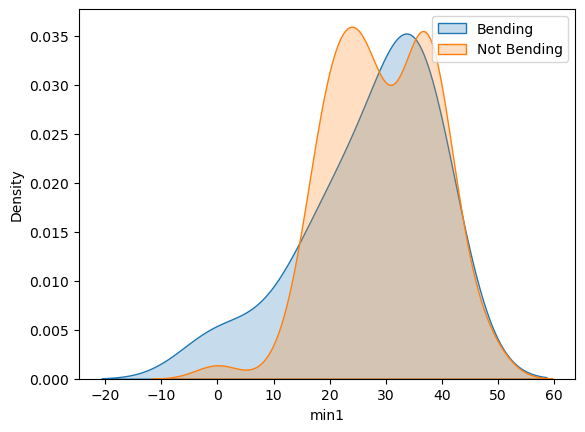

<Figure size 500x500 with 0 Axes>

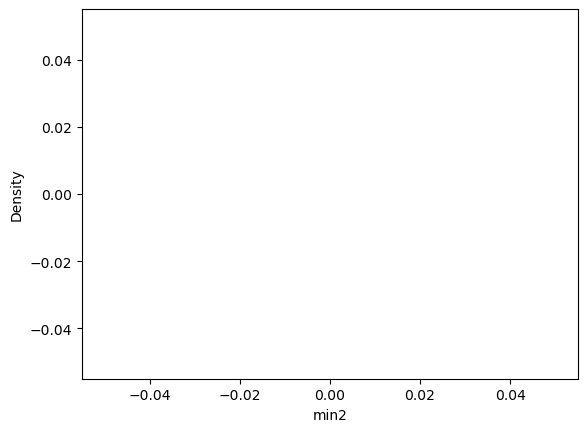

<Figure size 500x500 with 0 Axes>

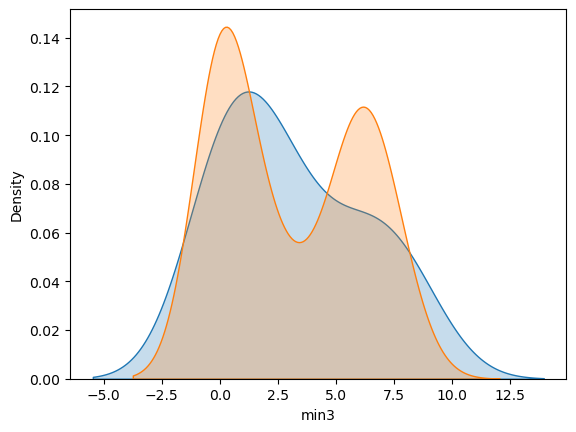

<Figure size 500x500 with 0 Axes>

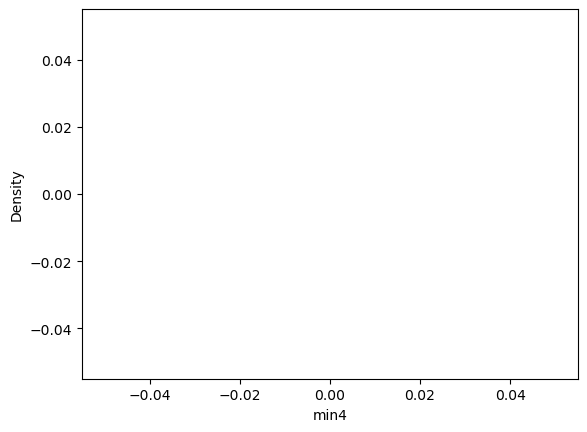

<Figure size 500x500 with 0 Axes>

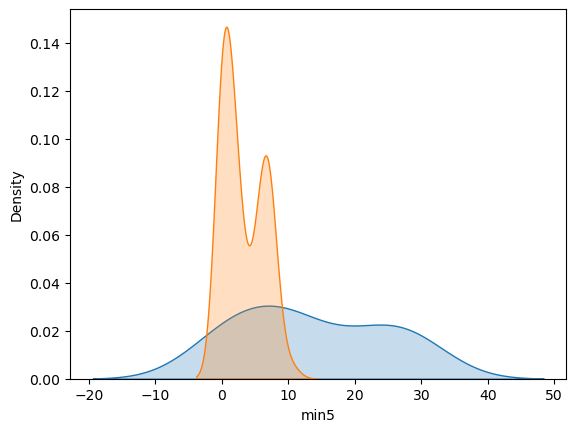

<Figure size 500x500 with 0 Axes>

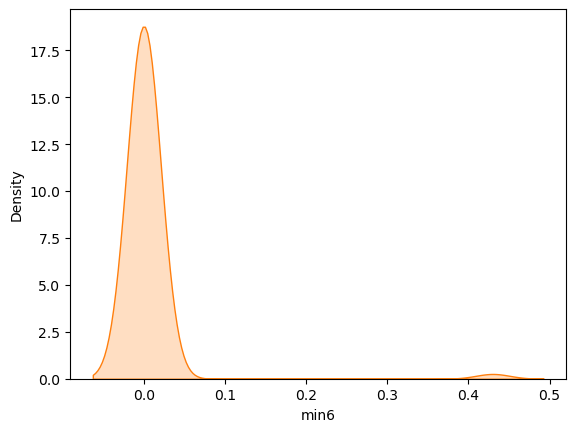

<Figure size 500x500 with 0 Axes>

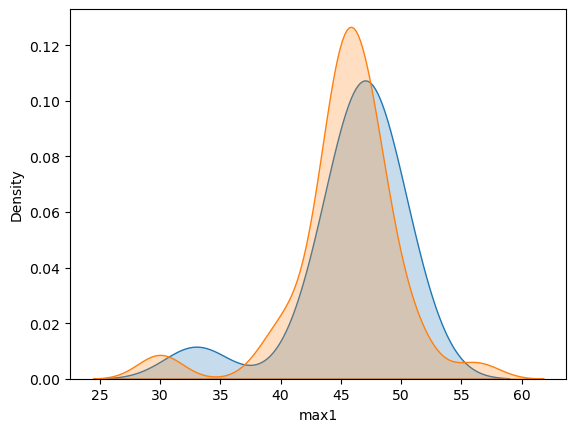

<Figure size 500x500 with 0 Axes>

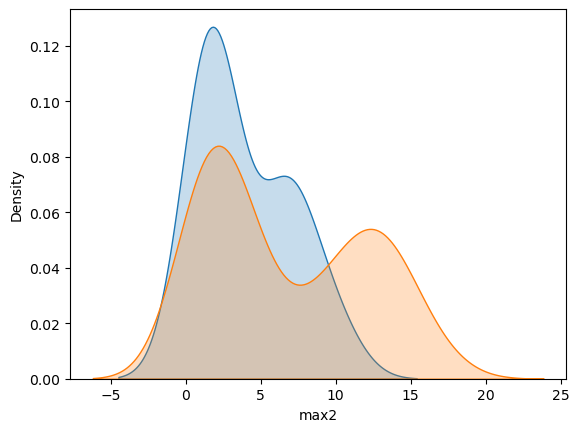

<Figure size 500x500 with 0 Axes>

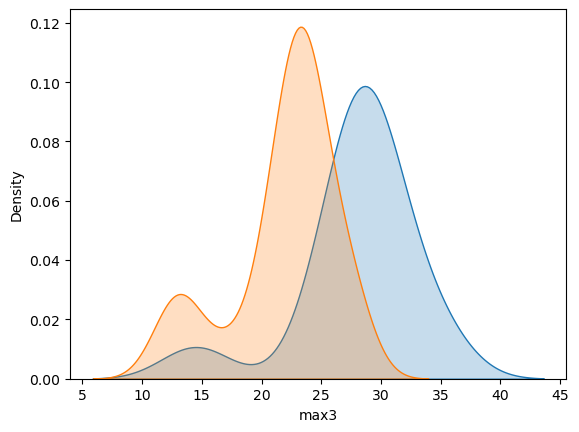

<Figure size 500x500 with 0 Axes>

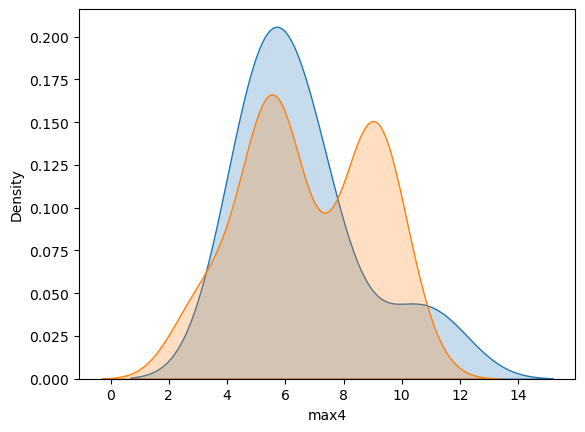

<Figure size 500x500 with 0 Axes>

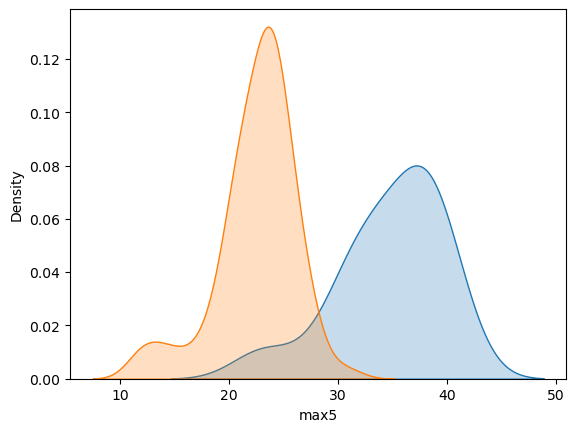

<Figure size 500x500 with 0 Axes>

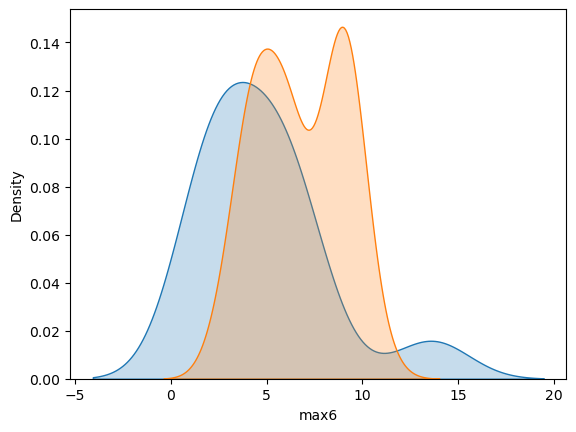

<Figure size 500x500 with 0 Axes>

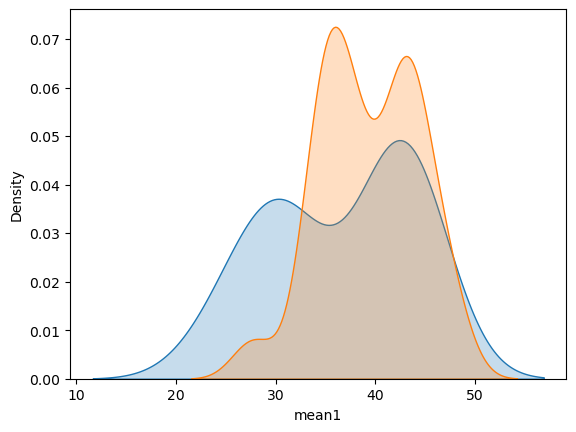

<Figure size 500x500 with 0 Axes>

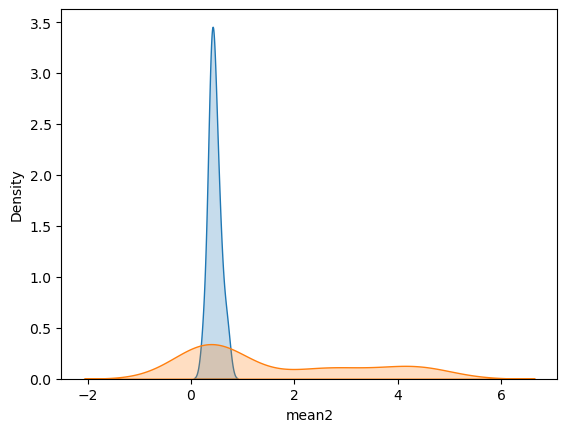

<Figure size 500x500 with 0 Axes>

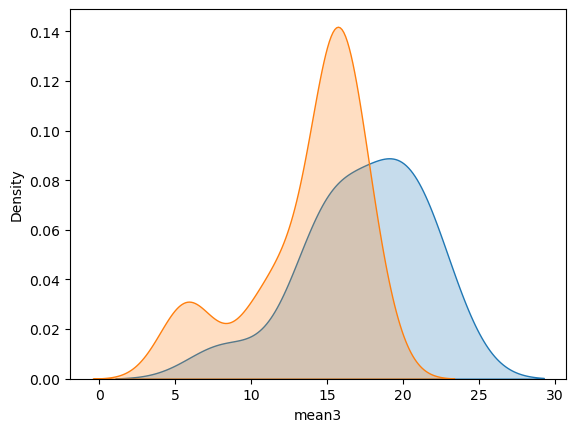

<Figure size 500x500 with 0 Axes>

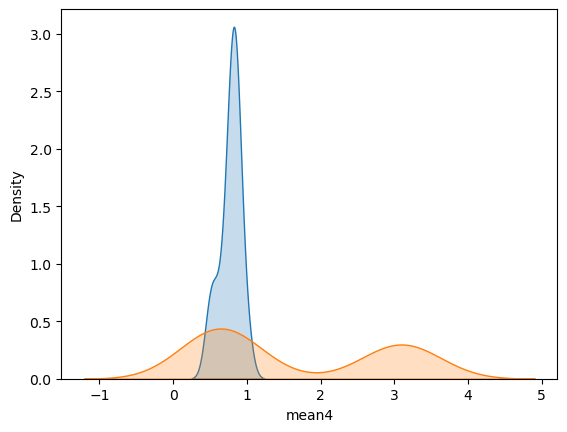

<Figure size 500x500 with 0 Axes>

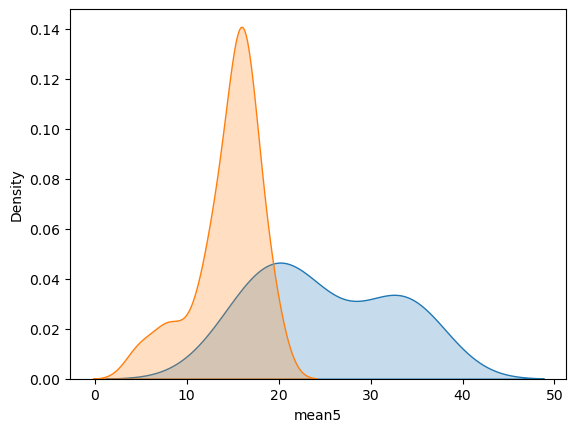

<Figure size 500x500 with 0 Axes>

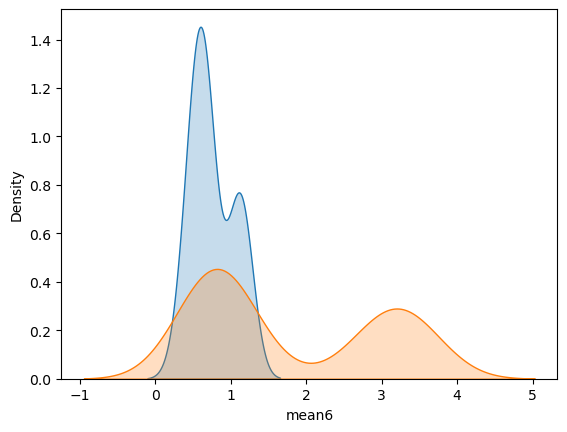

<Figure size 500x500 with 0 Axes>

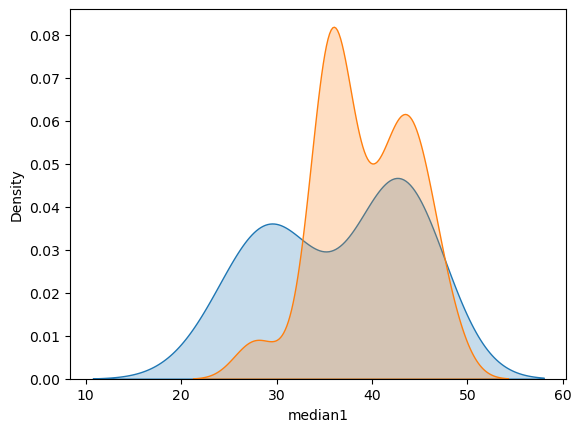

<Figure size 500x500 with 0 Axes>

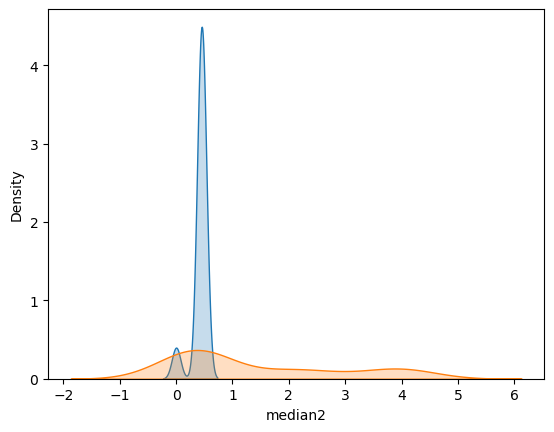

<Figure size 500x500 with 0 Axes>

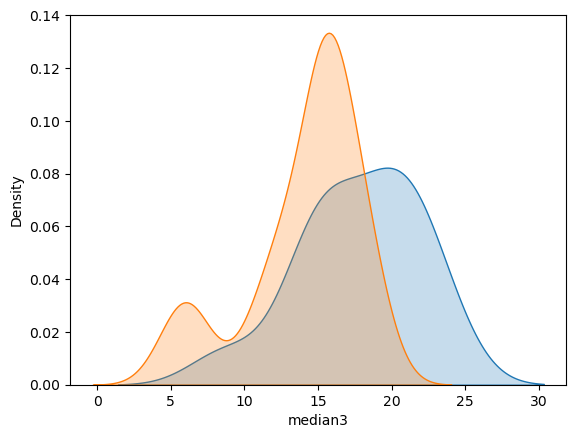

<Figure size 500x500 with 0 Axes>

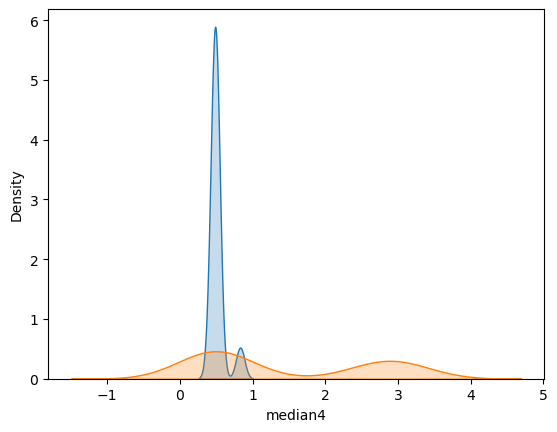

<Figure size 500x500 with 0 Axes>

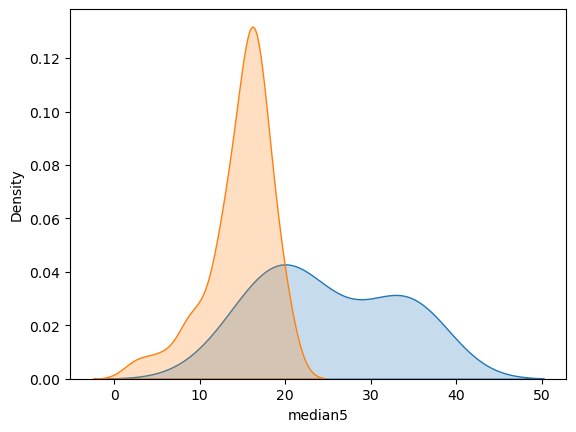

<Figure size 500x500 with 0 Axes>

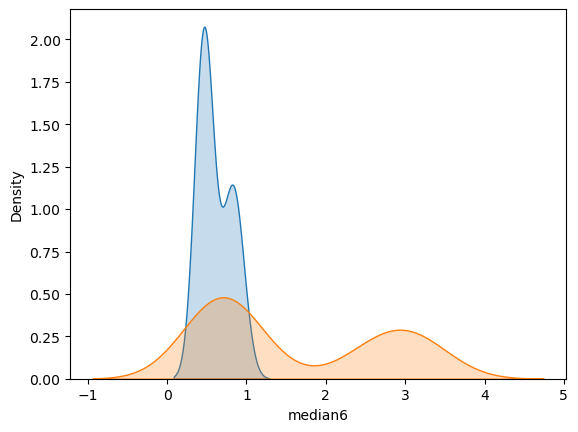

<Figure size 500x500 with 0 Axes>

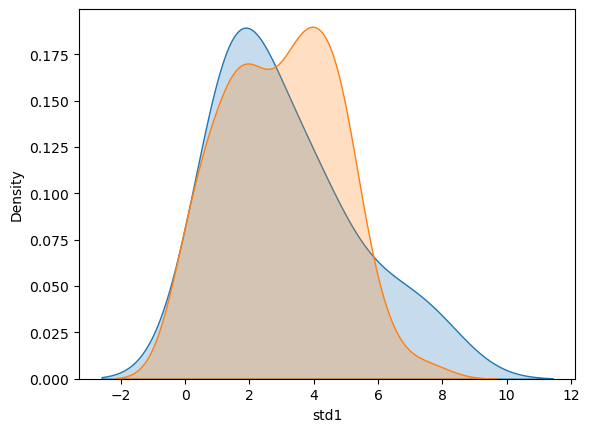

<Figure size 500x500 with 0 Axes>

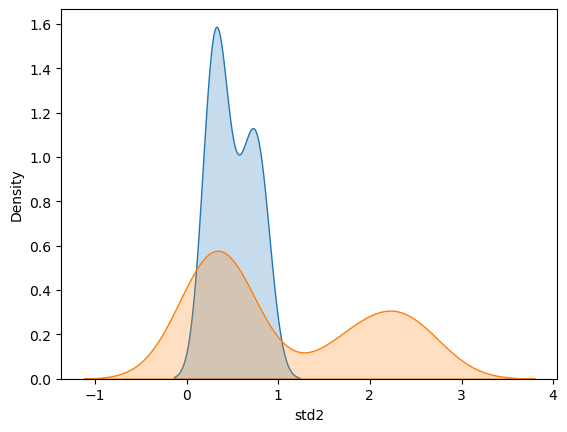

<Figure size 500x500 with 0 Axes>

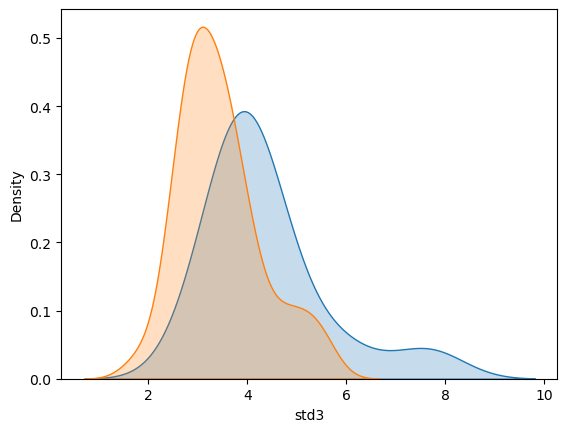

<Figure size 500x500 with 0 Axes>

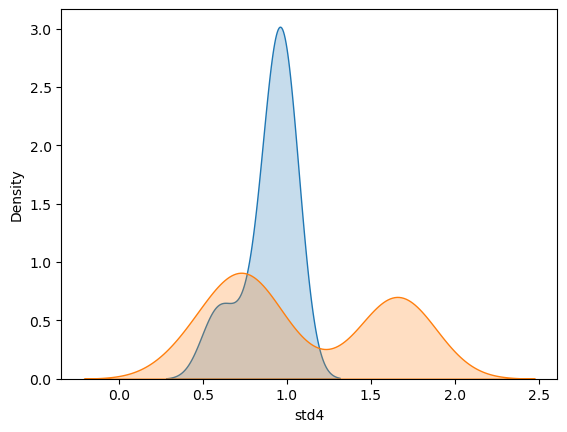

<Figure size 500x500 with 0 Axes>

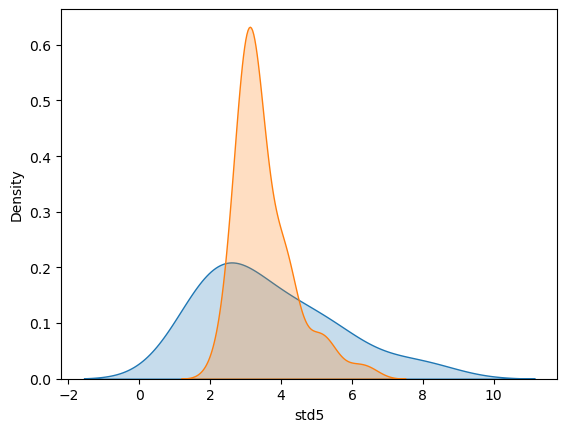

<Figure size 500x500 with 0 Axes>

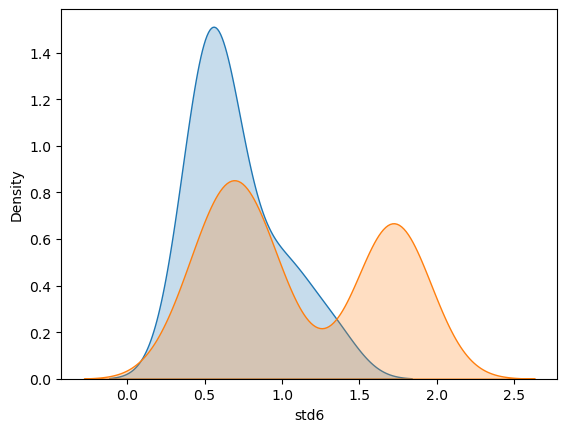

<Figure size 500x500 with 0 Axes>

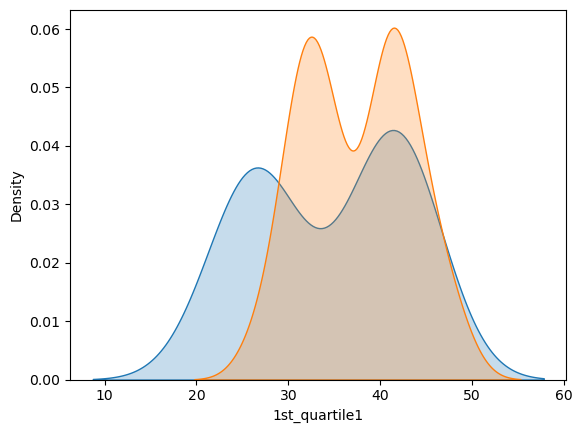

<Figure size 500x500 with 0 Axes>

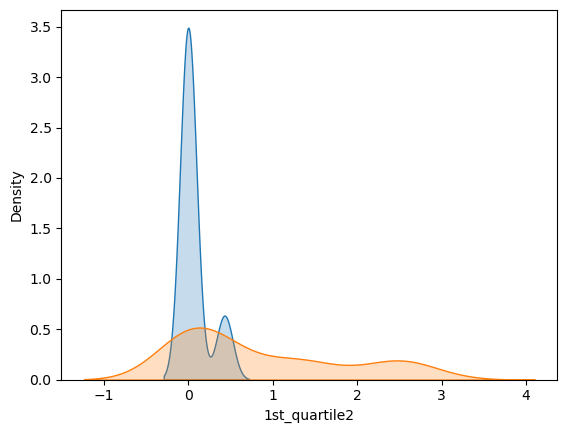

<Figure size 500x500 with 0 Axes>

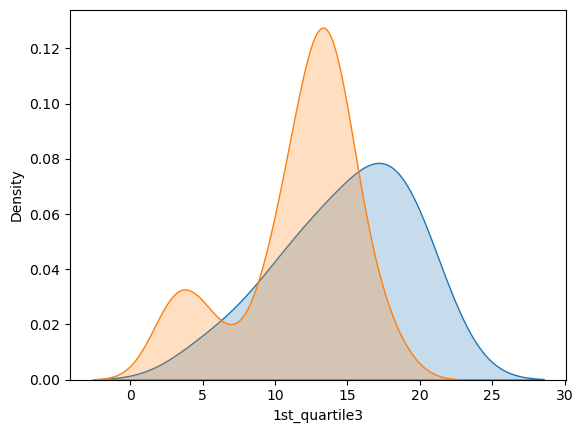

<Figure size 500x500 with 0 Axes>

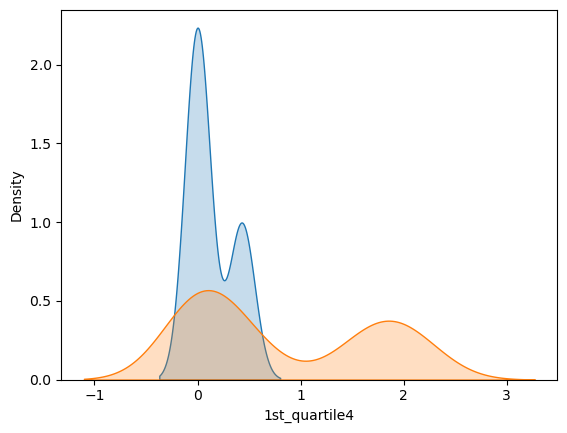

<Figure size 500x500 with 0 Axes>

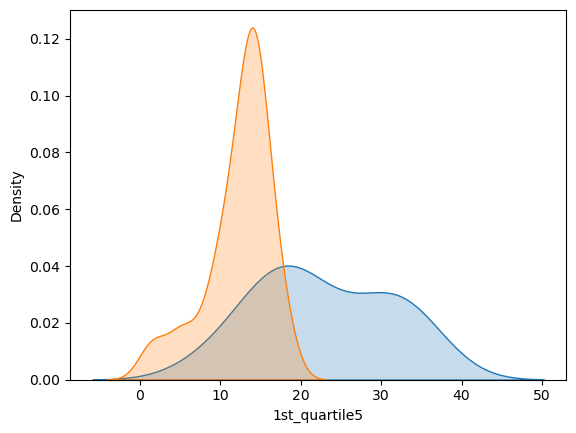

<Figure size 500x500 with 0 Axes>

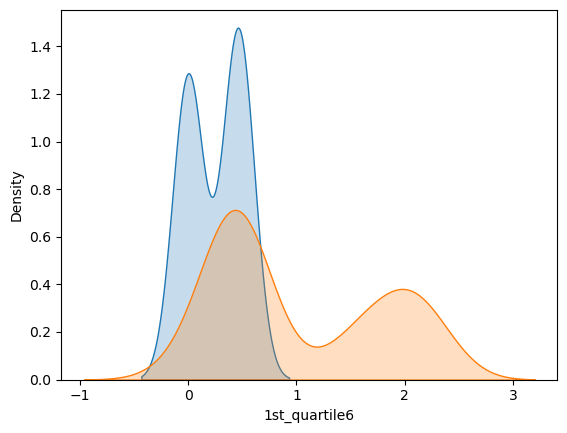

<Figure size 500x500 with 0 Axes>

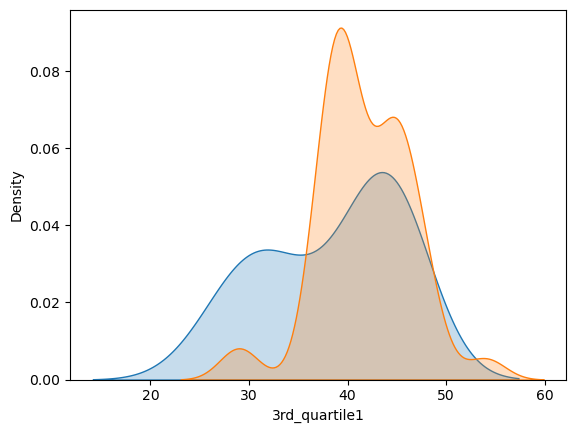

<Figure size 500x500 with 0 Axes>

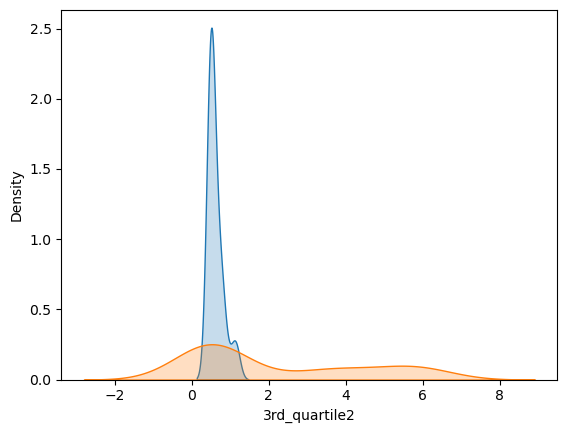

<Figure size 500x500 with 0 Axes>

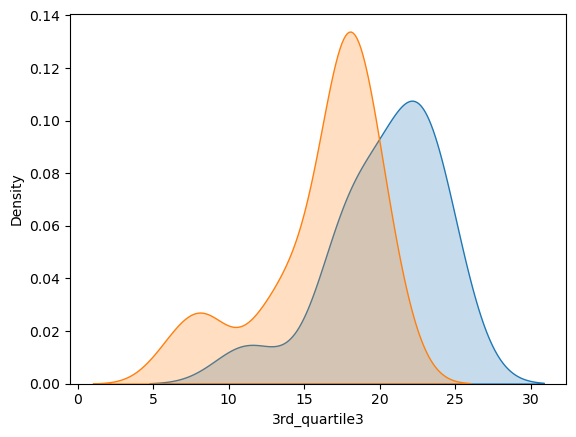

<Figure size 500x500 with 0 Axes>

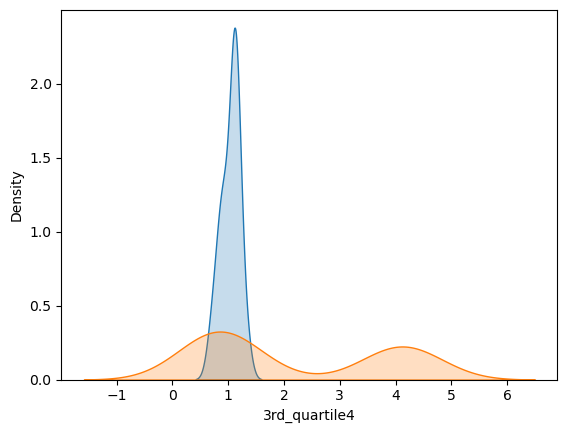

<Figure size 500x500 with 0 Axes>

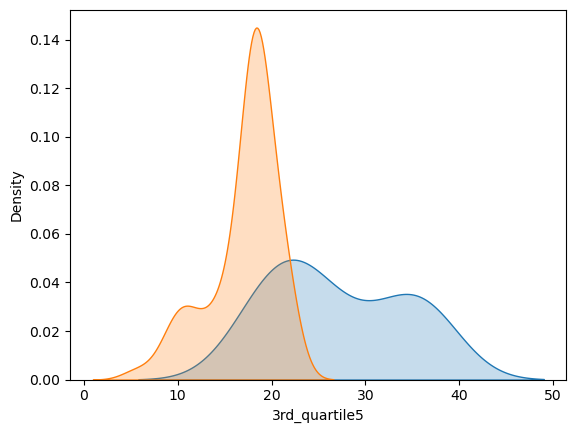

<Figure size 500x500 with 0 Axes>

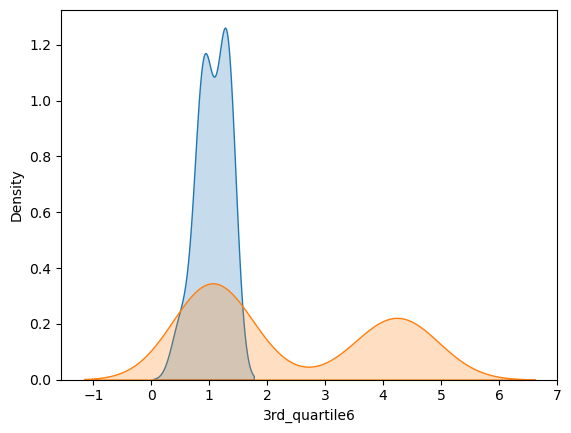

<Figure size 500x500 with 0 Axes>

In [129]:

data_frame = pd.DataFrame(data)
data_frame.loc[data_frame['label'].isin(['bending1', 'bending2']), 'label'] = 1
data_frame.loc[data_frame['label'] != 1, 'label'] = 0

for stat in Order_Stats:
    for i in range(1, 7):
        column_name = stat + str(i)
        
        bending_df = data_frame.loc[data_frame['label'] == 1, column_name]
        not_bending_df = data_frame.loc[data_frame['label'] == 0, column_name]
        
        sns.kdeplot(bending_df, label='Bending', shade=True)
        sns.kdeplot(not_bending_df, label='Not Bending', shade=True)
        
        # Only add the legend for the first subplot
        if stat == Order_Stats[0] and i == 1:
            plt.legend(loc='upper right')
        else:
            legend = plt.gca().get_legend()
            if legend:
                legend.remove()
        plt.figure(figsize=(5,5))
        plt.show()


Since this is a regression problem, the choice of important time-domain features will be majorly driven by the feasibility of demarkation and there should be relatively clear separated distribution and hence the choice would be -
From the above graphs we see these below 3 values to have most distinction

mean
median
std deviation

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [130]:
feature = get_actual_ordered_cols()
data_for_2a=load_data(train_og, feature)
data_for_2a


min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   35.00  47.40  43.954500   44.330  1.558835          43.00        45.0000   
1   33.00  47.75  42.179812   43.500  3.670666          39.15        45.0000   
2   33.00  45.75  41.678063   41.750  2.243490          41.33        42.7500   
3   37.00  48.00  43.454958   43.250  1.386098          42.50        45.0000   
4   36.25  48.00  43.969125   44.500  1.618364          43.31        44.6700   
..    ...    ...        ...      ...       ...            ...            ...   
64  20.75  46.25  34.763333   35.290  4.742208          31.67        38.2500   
65  21.50  51.00  34.935812   35.500  4.645944          32.00        38.0625   
66  18.33  47.67  34.333042   34.750  4.948770          31.25        38.0000   
67  18.33  45.75  34.599875   35.125  4.731790          31.50        38.0000   
68  15.50  43.67  34.225875   34.750  4.441798          31.25        37.2500   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6   max6  \
0    0.0   1.70  0.426250  ...        35.3625          36.50   0.0   1.79   
1    0.0   3.00  0.696042  ...        30.4575          36.33   0.0   2.18   
2    0.0   2.83  0.535979  ...        28.4575          31.25   0.0   1.79   
3    0.0   1.58  0.378083  ...        22.2500          24.00   0.0   5.26   
4    0.0   1.50  0.413125  ...        20.5000          23.75   0.0   2.96   
..   ...    ...       ...  ...            ...            ...   ...    ...   
64   0.0  12.68  4.223792  ...        14.2500          18.33   0.0   9.39   
65   0.0  12.21  4.115750  ...        14.2375          18.25   0.0  10.21   
66   0.0  12.48  4.396958  ...        13.7500          18.00   0.0   8.01   
67   0.0  15.37  4.398833  ...        14.0000          18.25   0.0   8.86   
68   0.0  17.24  4.354500  ...        14.3300          18.25   0.0   9.42   

       mean6  median6      std6  1st_quartile6  3rd_quartile6     label  
0   0.493292    0.430  0.513506           0.00         0.9400  bending1  
1   0.613521    0.500  0.524317           0.00         1.0000  bending1  
2   0.383292    0.430  0.389164           0.00         0.5000  bending1  
3   0.679646    0.500  0.622534           0.43         0.8700  bending1  
4   0.555312    0.490  0.487826           0.00         0.8300  bending1  
..       ...      ...       ...            ...            ...       ...  
64  3.288271    3.270  1.647528           2.05         4.3050   walking  
65  3.280021    3.015  1.700918           2.12         4.5000   walking  
66  3.261583    2.980  1.617290           2.05         4.3200   walking  
67  3.289542    3.015  1.680170           2.12         4.2600   walking  
68  3.479542    3.270  1.761146           2.24         4.5375   walking  

[69 rows x 43 columns]

        mean1  median1      std1     mean2  median2      std2     mean6  \
0   43.954500   44.330  1.558835  0.426250    0.470  0.338690  0.493292   
1   42.179812   43.500  3.670666  0.696042    0.500  0.630860  0.613521   
2   41.678063   41.750  2.243490  0.535979    0.500  0.405469  0.383292   
3   43.454958   43.250  1.386098  0.378083    0.470  0.315566  0.679646   
4   43.969125   44.500  1.618364  0.413125    0.470  0.263111  0.555312   
..        ...      ...       ...       ...      ...       ...       ...   
64  34.763333   35.290  4.742208  4.223792    3.900  2.278004  3.288271   
65  34.935812   35.500  4.645944  4.115750    3.845  2.335243  3.280021   
66  34.333042   34.750  4.948770  4.396958    3.900  2.568680  3.261583   
67  34.599875   35.125  4.731790  4.398833    4.025  2.538521  3.289542   
68  34.225875   34.750  4.441798  4.354500    3.900  2.518991  3.479542   

    median6      std6  label  
0     0.430  0.513506      1  
1     0.500  0.524317      1  
2     

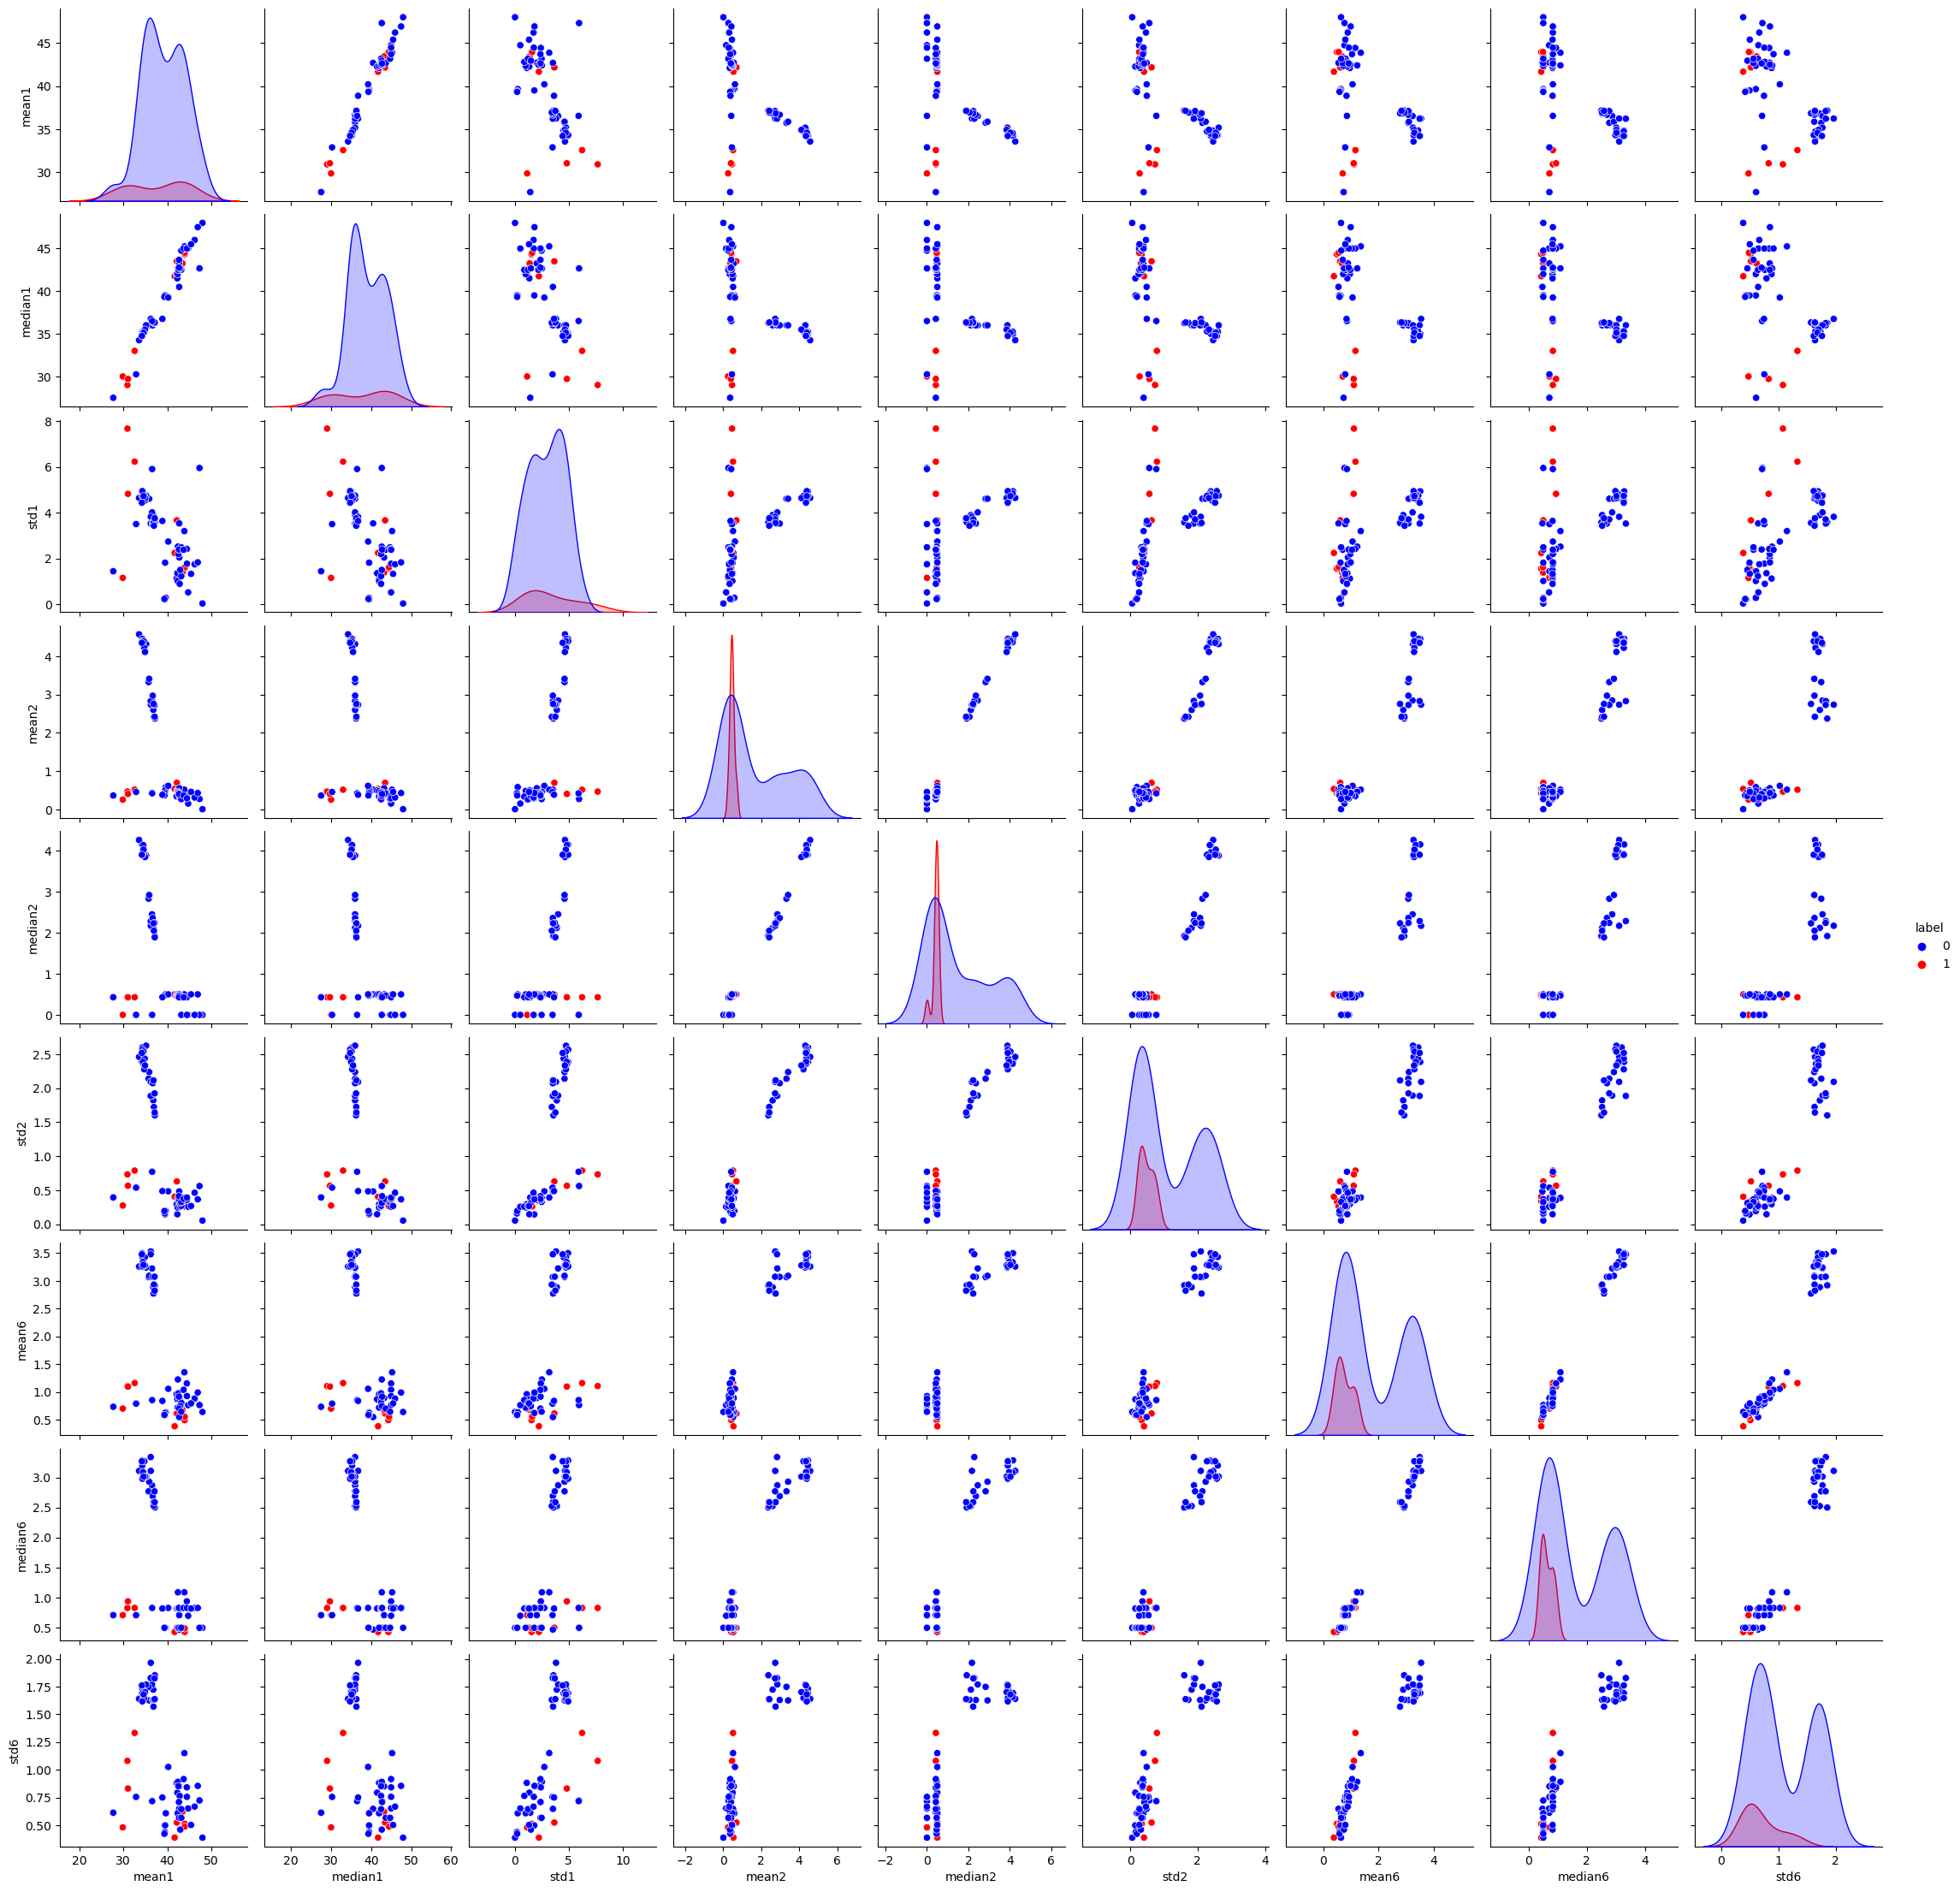

In [131]:
train_table = data_for_2a.loc[:, ['mean1', 'median1', 'std1', 'mean2', 
                    'median2', 'std2', 'mean6', 'median6', 'std6', 'label']]

train_table['label'] = train_table['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)  
# train_table['activity_class'] = train_table['label'].apply(lambda x: 'Bending' if x==1 else 'Other')
print(train_table)



sp = sns.pairplot(train_table, hue='label', palette={1: 'red', 0: 'blue'})
plt.show()








#### ii. Splitted Plots

In [132]:
Xs=[]
for i in range(1, 13):        
    for stat in Order_Stats:
        Xs.append(f'{stat}{i}')
# print(Xs)

train_data_two = load_data(train_og,Xs,segs=2)
test_data_two = load_data(test,Xs,segs=2)
print(train_data_two.shape)
print(test_data_two.shape)
train_data_two

(69, 85)
(19, 85)


min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   36.50  46.50  44.057167   44.500  1.556971        43.2500        45.0000   
1   33.75  47.75  43.278875   45.000  3.473355        42.0000        45.2500   
2   33.00  45.75  41.621208   42.330  3.118644        39.6525        44.2500   
3   39.00  48.00  44.117042   45.000  1.359836        43.5000        45.0000   
4   36.67  45.00  43.486208   43.710  1.281976        42.3300        44.5000   
..    ...    ...        ...      ...       ...            ...            ...   
64  22.33  46.00  34.966250   35.500  4.733014        32.0000        38.7500   
65  21.50  45.67  34.737042   35.500  4.276717        32.0000        37.7500   
66  18.33  45.00  33.886458   34.375  5.143776        30.4575        37.5000   
67  18.33  44.00  34.836458   35.750  4.869092        32.0000        38.6900   
68  23.00  42.75  34.329333   34.710  4.549837        31.3100        37.5425   

    min2   max2     mean2  ...  1st_quartile11  3rd_quartile11  min12  max12  \
0    0.0   1.50  0.381042  ...         33.0000         36.2500   0.00   1.50   
1    0.0   3.00  0.673292  ...         28.7500         33.7500   0.00   2.18   
2    0.0   2.83  0.623083  ...         28.3100         30.5625   0.00   1.50   
3    0.0   1.30  0.250042  ...         22.5000         23.7500   0.00   4.06   
4    0.0   1.30  0.378667  ...         21.0000         23.5000   0.00   2.96   
..   ...    ...       ...  ...             ...             ...    ...    ...   
64   0.0  12.68  4.207958  ...         14.0000         18.5000   0.00   9.39   
65   0.0  12.21  4.217333  ...         14.5000         18.2500   0.00  10.21   
66   0.0  12.44  4.332208  ...         13.6275         18.2500   0.00   8.01   
67   0.0  12.38  4.257750  ...         13.9375         18.2500   0.47   8.84   
68   0.0  14.50  4.315917  ...         14.3300         18.0000   0.43   9.12   

      mean12  median12     std12  1st_quartile12  3rd_quartile12     label  
0   0.388333     0.000  0.478528          0.0000          0.7100  bending1  
1   0.586083     0.470  0.491873          0.0000          0.8700  bending1  
2   0.347500     0.430  0.363144          0.0000          0.5000  bending1  
3   0.543875     0.500  0.473445          0.4300          0.7100  bending1  
4   0.585750     0.500  0.487918          0.4225          0.8300  bending1  
..       ...       ...       ...             ...             ...       ...  
64  3.430208     3.350  1.647979          2.1700          4.4400   walking  
65  3.225917     3.085  1.665326          2.0500          4.3500   walking  
66  3.274750     2.955  1.670593          2.0500          4.4375   walking  
67  3.409458     3.110  1.707089          2.1700          4.3450   walking  
68  3.577833     3.290  1.794112          2.2900          4.7250   walking  

[69 rows x 85 columns]

        mean1  median1      std1     mean2  median2      std2     mean6  \
0   44.057167   44.500  1.556971  0.381042    0.470  0.329540  0.598250   
1   43.278875   45.000  3.473355  0.673292    0.485  0.634285  0.640958   
2   41.621208   42.330  3.118644  0.623083    0.500  0.489595  0.419083   
3   44.117042   45.000  1.359836  0.250042    0.000  0.314099  0.815417   
4   43.486208   43.710  1.281976  0.378667    0.470  0.284434  0.524875   
..        ...      ...       ...       ...      ...       ...       ...   
64  34.966250   35.500  4.733014  4.207958    3.900  2.331940  3.146333   
65  34.737042   35.500  4.276717  4.217333    4.030  2.337759  3.334125   
66  33.886458   34.375  5.143776  4.332208    3.900  2.453111  3.248417   
67  34.836458   35.750  4.869092  4.257750    3.770  2.512633  3.169625   
68  34.329333   34.710  4.549837  4.315917    3.880  2.470266  3.381250   

    median6      std6      mean7  median7      std7     mean8  median8  \
0     0.500  0.526656  43

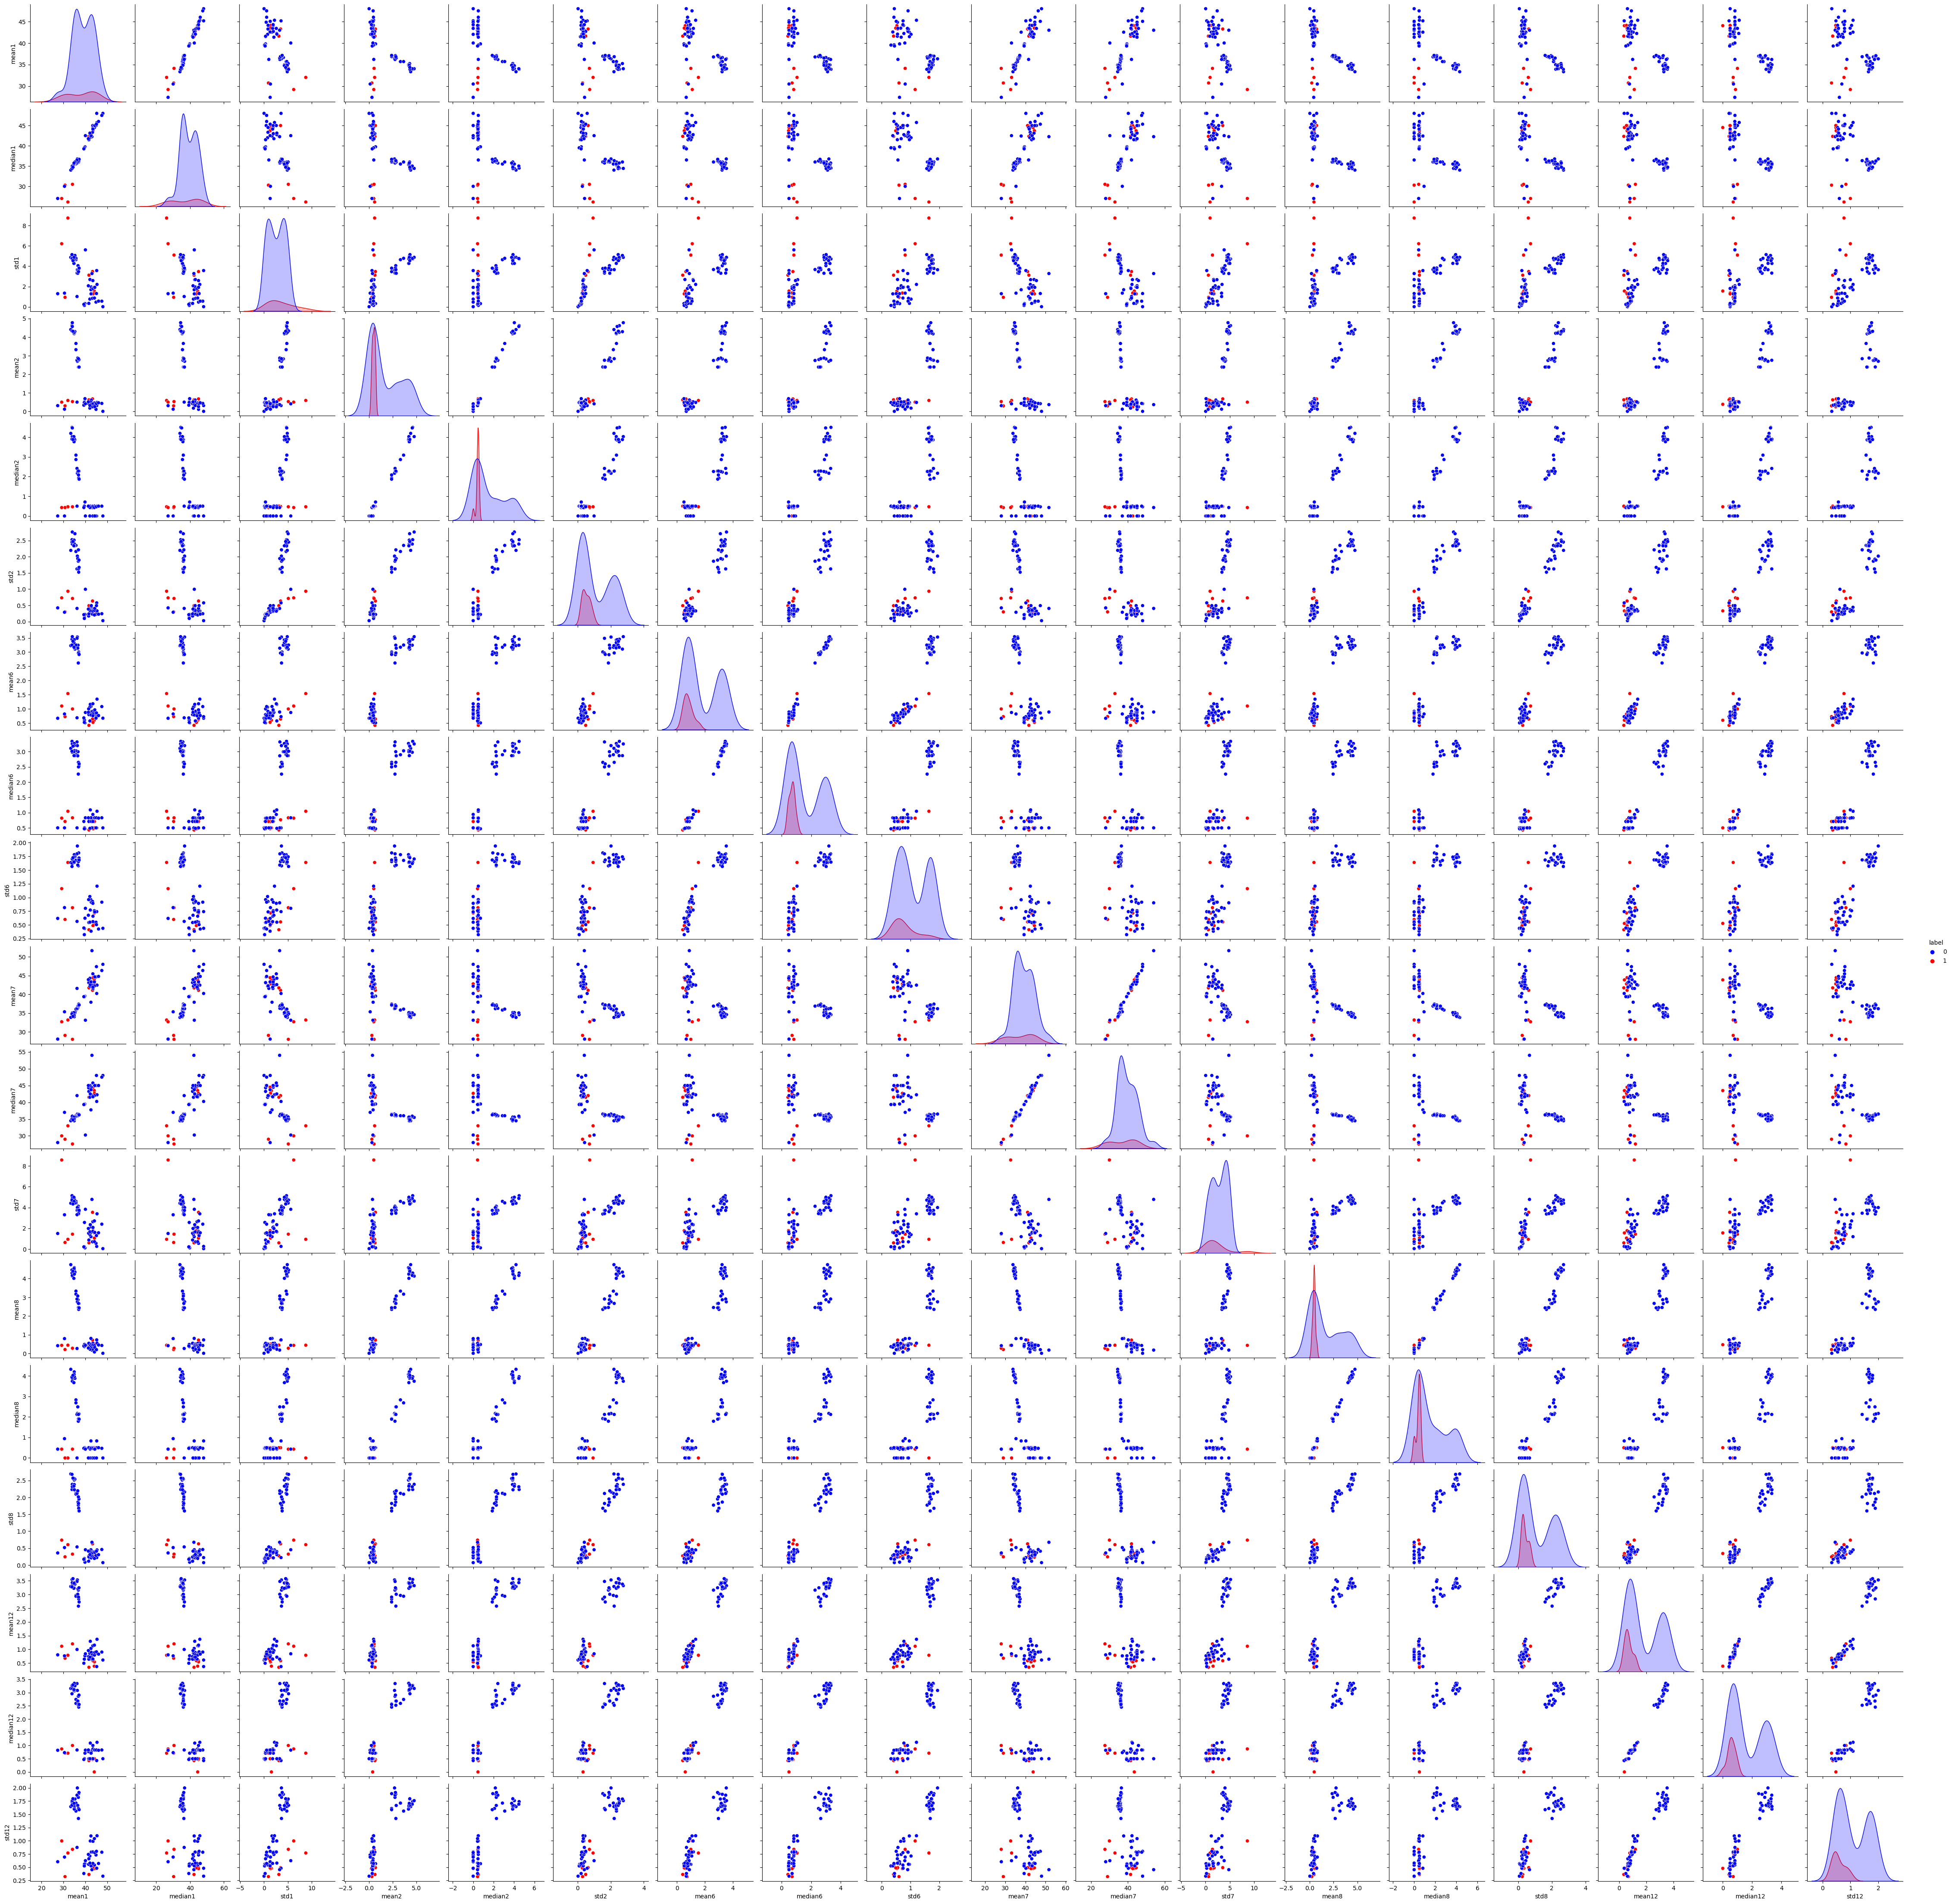

In [133]:
train_table = train_data_two.loc[:, ['mean1', 'median1', 'std1', 'mean2', 
                    'median2', 'std2', 'mean6', 'median6', 'std6','mean7', 'median7', 'std7', 'mean8', 
                    'median8', 'std8', 'mean12', 'median12', 'std12', 'label']]

train_table['label'] = train_table['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)
# train_table['activity_class'] = train_table['label'].apply(lambda x: 'Bending' if x==1 else 'Other')
print(train_table)






sp = sns.pairplot(train_table, hue='label', palette={1: 'red',0: 'blue'})
plt.show()



### Observation
After we break each time series into two equal-length time series, the scatterplot of both the classes (bending and non-bending) is more separable and easy to visualize.

##### iii) logistic regression

In [134]:


def oversampling(data_set):
   
    
    label_0, label_1 = data_set['label'].value_counts()
    
   
    if 0 in [label_0, label_1]:
        print("Cannot perform oversampling. One of the classes has zero instances.")
        return data_set

    minor_label = 0 if label_0 < label_1 else 1
    major_label = 1 - minor_label

    minor_ds = data_set[data_set['label'] == minor_label]
    major_ds = data_set[data_set['label'] == major_label]
  
    minor_ds = resample(minor_ds, replace=True, random_state=60, n_samples=label_1 if minor_label == 0 else label_0)

    return pd.concat([major_ds, minor_ds])


In [135]:

def logistic_regression(train_files, test_files, l_val, fold_count, oversample=False, penalty='none'):
    Xs=[]
    
    for i in range(1,6*l_val+1):
        for stat in Stats:
            Xs.append(f'{stat}{i}')
 
    training = load_data(train_files, features,l_val)
    training['label'] = training['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
    
    if oversample:
        print('Oversampling of data')
        training = oversampling(training)
    
    trainX, trainY = training.iloc[:, :-1],training.iloc[:, -1]
    
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    return model, selector
                

In [136]:

combination = {
    'pair(l_val, p (count of features used))': [],
    'score': []
}
for l in range(1,21):
    model, selector = logistic_regression(train_og, test, l,5, oversample=False)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    combination['pair(l_val, p (count of features used))'].append((l, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

pair(l_val, p (count of features used))   score
0                                   (1, 6)  1.0000
1                                   (2, 2)  0.9714
2                                  (3, 10)  0.9857
3                                   (4, 2)  0.9857
4                                  (5, 17)  0.9857
5                                   (6, 8)  0.9857
6                                   (7, 5)  0.9857
7                                   (8, 7)  0.9857
8                                   (9, 4)  0.9857
9                                 (10, 11)  0.9714
10                                 (11, 4)  0.9714
11                                 (12, 3)  0.9714
12                                 (13, 4)  0.9714
13                                 (14, 4)  0.9714
14                                 (15, 4)  0.9714
15                                 (16, 4)  0.9714
16                                 (17, 5)  0.9714
17                                 (18, 3)  0.9429
18                                 (19, 8)  0.9429
19                                 (20, 3)  0.9560

#### The Right and the Wrong Way to Do Cross-validation: 

The wrong way to perform cross validation is by including the samples on which the classifier (i.e. the k group) is to be run in the feature selection step. i.e. RFE before performing Cross Validation
The purpose of cross-validation is to estimate the error on test data. We do not want to deprive our algorithm with the knowledge of the various predictors available at the disposal of our dataset. Hence, the correct way would be to do the Recursive Feature Elimination along with Cross Validation.

The right way to perform cross validation is by making sure the samples on which the classifier (i.e. the k group) is to be run should be left out during the feature selection step. This ensures that the predictors are not biased and the prediction would be natural. 

#### iv. Confusion Matrix

Since we got the best l,p score of 1 for l=1, we will now train using l=1

In [137]:
Xs=[]
for i in range(1,7):        
    for stat in Order_Stats:
        Xs.append(f'{stat}{i}')
classifier, selector = logistic_regression(train_og, test,1,5)
selected_features = [ft for i, ft in enumerate(Xs) if selector.support_[i]]
selected_features




['mean1', '3rd_quartile1', 'max2', 'min5', 'max5', '1st_quartile5']

In [138]:
train_set = load_data(train_og, selected_features)
train_set['label'] = train_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   


trainX, trainY = train_set.iloc[:, :-1],train_set.iloc[:, -1]
df_temp = trainX.loc[:, selected_features]
const_val = sm.add_constant(df_temp)
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)
summary = model.fit().summary()
print(summary)

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        21:23:05   Log-Likelihood:            -1.0478e-09
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.0240   2.87e+07  -1.06e-07      1.000   -5.62e+07    5.62e+07
mean1            -3.4110   3.11e+05   -1.1e-05      1.00

In [139]:
classifier.fit(trainX.loc[:, selected_features],trainY)
y_pred = classifier.predict(trainX.loc[:, selected_features])
cm = confusion_matrix(trainY, y_pred)
cm

array([[60,  0],
       [ 0,  9]], dtype=int64)

The AUC is  0.0
The AUC is  1.0


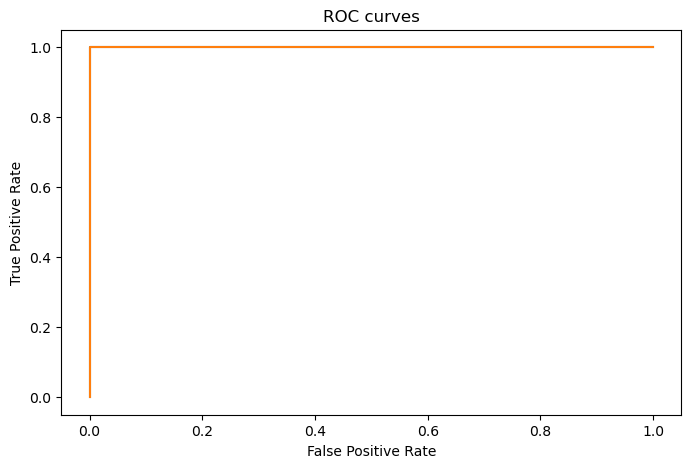

In [140]:
y_pred_prob = classifier.predict_proba(trainX.loc[:, selected_features])
plt.figure(figsize=(8,5))
plt.title("ROC curves")

for i, c in enumerate(classifier.classes_):
    print("The AUC is ",metrics.roc_auc_score(trainY,y_pred_prob[:, i]))
    fpr, tpr, _ = roc_curve(trainY,y_pred_prob[:, i], pos_label=c)
#     print(fpr,tpr)
    plt.plot(fpr, tpr, label=f"Class: {c}; ROC Curve Area: {round(auc(fpr, tpr), 4)}")    
    

    
    
plt.plot()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

#### v. Test Classifier

In [141]:
test_set = load_data(test, selected_features)

test_set['label'] = test_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0) 
testX, testY = test_set.iloc[:, :-1],test_set.iloc[:, -1]

print("The test data accuracy score is",classifier.score(testX,testY))

testX


The test data accuracy score is 1.0


mean1  3rd_quartile1   max2   min5   max5  1st_quartile5
0   40.624792        42.0000   1.30  27.25  38.25        33.0000
1   42.812812        43.6700   1.22  27.67  38.50        32.0000
2   24.562958        26.5000   6.87  10.67  30.00        20.5000
3   27.464604        30.0000   7.76   0.00  33.00        15.0000
4   37.177042        40.2500   8.58   7.00  25.50        17.9500
5   37.561187        40.2500   9.91  10.50  24.33        18.0000
6   37.058708        40.0625  14.17   7.50  24.25        16.0000
7   27.716375        29.0000   1.79   0.00  21.00         5.5000
8   44.182937        48.0000   3.11   0.00  12.75         2.0000
9   48.004167        48.0000   0.43   0.00  12.00         4.6700
10  42.363563        43.5000   4.44   1.00  28.00        10.1875
11  45.917667        46.5000   4.87   2.00  24.00        16.5000
12  45.239667        45.3300   1.00   4.75  26.75        17.6275
13  44.334729        46.5000   3.90   0.00  23.00         9.3300
14  43.174938        44.5000   2.12   2.00  21.25        12.7500
15  42.760562        45.3725   3.34   1.33  21.33        13.0000
16  34.227771        37.7500  14.50   6.75  26.00        14.7500
17  33.509729        36.7500  13.05   7.25  25.00        14.6275
18  34.660583        38.2500  13.44   7.00  24.50        14.2500

In the series of training for different values of l we got score as 1 for l=1. The test and train score was both obtained as 1.

#### vi. Separation

I employed stratified K-fold validation in this scenario. As observed in the summary , when we did model.summary(), the Maximum Likelihood Estimator is non-existent and the parameters are undefined. This discovery suggests that the distinct separation of the classes might be leading to inconsistencies in determining the regression parameters.

#### vii. Imbalance

array([[60,  0],
       [ 0,  9]], dtype=int64) -  imbalanced =  69 instances of not bending and not bending of which, 60 is not bending and 9 is bending
### Hence building a logistic regression using case controlled sampling/over sampling

In [142]:

combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1,21):
    model, selector = logistic_regression(train, test,l_val,5, oversample=True)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data
Oversampling of data


pair(l, p)   score
0      (1, 4)  1.0000
1      (2, 4)  1.0000
2      (3, 4)  1.0000
3      (4, 2)  0.9933
4     (5, 11)  0.9933
5      (6, 3)  0.9933
6      (7, 4)  0.9933
7      (8, 4)  0.9933
8      (9, 5)  0.9933
9     (10, 4)  0.9933
10    (11, 4)  0.9933
11    (12, 4)  0.9933
12    (13, 3)  0.9933
13    (14, 3)  0.9933
14    (15, 4)  0.9933
15    (16, 4)  0.9933
16    (17, 4)  0.9933
17   (18, 10)  0.9933
18    (19, 4)  0.9800
19    (20, 9)  0.9867

In [143]:
Xs=[]
for i in range(1,7):        
    for stat in Order_Stats:
        Xs.append(f'{stat}{i}')
classifier, selector = logistic_regression(train_og, test,1,5,oversample=True)
selected_features = [ft for i, ft in enumerate(Xs) if selector.support_[i]]
selected_features


Oversampling of data


['3rd_quartile1', 'median3', 'min5', 'max5', 'mean5', '1st_quartile5', 'max6']

In [144]:
train_set = load_data(train_og, selected_features)
train_set['label'] = train_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)
train_set = oversampling(train_set)
trainX, trainY = train_set.iloc[:, :-1],train_set.iloc[:, -1]
classifier.fit(trainX.loc[:, selected_features],trainY)
y_pred = classifier.predict(trainX.loc[:, selected_features])
confusionmatrix = confusion_matrix(trainY, y_pred)
confusionmatrix






array([[60,  0],
       [ 0, 60]], dtype=int64)

The AUC is  0.0
The AUC is  1.0


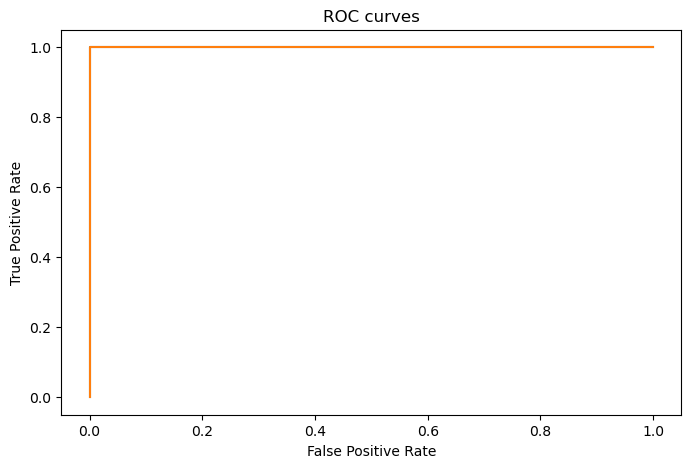

In [145]:
y_pred_prob = classifier.predict_proba(trainX.loc[:, selected_features])
plt.figure(figsize=(8,5))
plt.title("ROC curves")

for i, c in enumerate(classifier.classes_):
    print("The AUC is ",metrics.roc_auc_score(trainY,y_pred_prob[:, i]))
    fpr, tpr, _ = roc_curve(trainY,y_pred_prob[:, i], pos_label=c)
#     print(fpr,tpr)
    plt.plot(fpr, tpr, label=f"Class: {c}; ROC Curve Area: {round(auc(fpr, tpr), 4)}")    
    

    
    
plt.plot()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

In [146]:
test_set = load_data(test, selected_features)
test_set['label'] = test_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)

testX, testY = test_set.iloc[:, :-1],test_set.iloc[:, -1]
classifier.fit(testX.loc[:, selected_features],testY)
y_pred = classifier.predict(testX.loc[:, selected_features])
confusionmatrix = confusion_matrix(testY, y_pred)
confusionmatrix

array([[15,  0],
       [ 0,  4]], dtype=int64)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [147]:
max_test_accuracy = 0
optimal_L = 1

In [148]:
def logistic_regression_l1(train_files, test_files, oversample=False):
       
    for l_val in range(1,21):
        Xs = []
        for i in range(1, 6*l_val+1):
            for stat in Order_Stats:
                Xs.append(f'{stat}{i}')
        
        train_set = load_data(train_files, Xs, l_val)
        train_set['label'] = train_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
        
        test_set = load_data(test_files, Xs, l_val)
        test_set['label'] = test_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
        
        
        
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
        
#         validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
        
        model = LogisticRegressionCV(
#            
            cv=5,
            penalty='l1', 
            solver='liblinear',
            max_iter=100, 
            scoring='accuracy',
            random_state=69
        )
       
   
        model.fit(trainX, trainY)
        train_score = model.score(trainX, trainY)

        test_score = model.score(testX, testY)
        print(f' L: {l_val}  train_score: {train_score} test_score: {test_score}')
        
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            print('\n')
            print(f'max accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
         
    
logistic_regression_l1(train_og, test)



 L: 1  train_score: 1.0 test_score: 1.0
 L: 2  train_score: 1.0 test_score: 1.0
 L: 3  train_score: 1.0 test_score: 1.0
 L: 4  train_score: 1.0 test_score: 0.9473684210526315
 L: 5  train_score: 1.0 test_score: 0.9473684210526315
 L: 6  train_score: 1.0 test_score: 0.9473684210526315
 L: 7  train_score: 1.0 test_score: 1.0
 L: 8  train_score: 1.0 test_score: 0.9473684210526315
 L: 9  train_score: 1.0 test_score: 0.9473684210526315
 L: 10  train_score: 1.0 test_score: 0.9473684210526315
 L: 11  train_score: 1.0 test_score: 0.9473684210526315
 L: 12  train_score: 1.0 test_score: 1.0
 L: 13  train_score: 1.0 test_score: 1.0
 L: 14  train_score: 1.0 test_score: 0.9473684210526315
 L: 15  train_score: 1.0 test_score: 1.0
 L: 16  train_score: 1.0 test_score: 1.0
 L: 17  train_score: 1.0 test_score: 1.0
 L: 18  train_score: 1.0 test_score: 0.9473684210526315
 L: 19  train_score: 1.0 test_score: 0.9473684210526315
 L: 20  train_score: 1.0 test_score: 0.9473684210526315


max accuracy is 1.0 (f

In [149]:
  def plot_curve(classifier,Y1,Y2):
    for i, c in enumerate(classifier.classes_):
        print("The AUC is ",metrics.roc_auc_score(Y1,Y2[:, i]))
        fpr, tpr, _ = roc_curve(Y1,Y2[:, i], pos_label=c)
    #     print(fpr,tpr)
        plt.plot(fpr, tpr, label=f"Class: {c}; ROC Curve Area: {round(auc(fpr, tpr), 4)}")      
    plt.plot()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

[[15  0]
 [ 0  4]]
train ROC
The AUC is  0.0
The AUC is  1.0


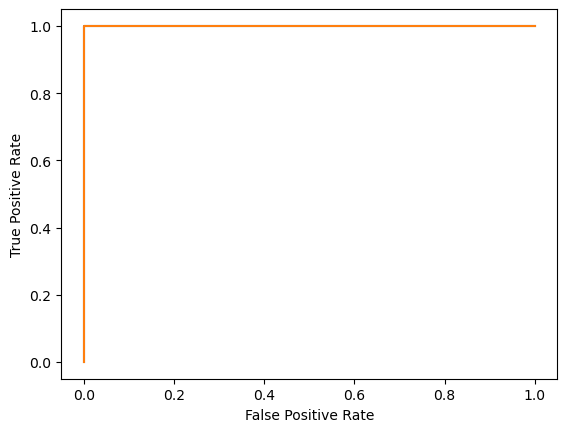

test ROC
The AUC is  0.0
The AUC is  1.0


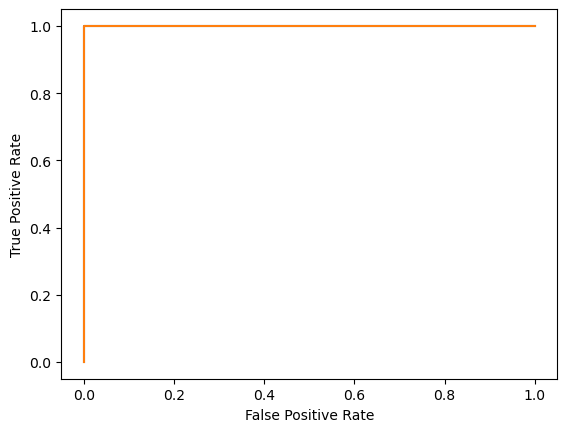

In [150]:
def logistic_regression_l1_bestl(train_files, test_files, oversample=False):
    Xs = [] 
    l_val=1
    for i in range(1, 6*l_val+1):
        for stat in Order_Stats:
                Xs.append(f'{stat}{i}')        
    train_set = load_data(train_files, Xs, l_val)
    train_set['label'] = train_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
        
    test_set = load_data(test_files, Xs, l_val)
    test_set['label'] = test_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0) 
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

    model = LogisticRegression(
      
            penalty='l1', 
            solver = 'liblinear',
            max_iter=100         
           
        )
    model.fit(trainX,trainY)
    train_proba = model.predict_proba(trainX)
    test_proba = model.predict_proba(testX)
    y_pred=model.predict(testX)
    cm = confusion_matrix(testY, y_pred)
    print(cm)
    print('train ROC')
    plot_curve(model,trainY,train_proba)
    print('test ROC')
    plot_curve(model,testY,test_proba)
logistic_regression_l1_bestl(train_og, test)

#### ii. Comparison

The L1-penalized logistic regression has better performance in terms of accuracy when tested on the test data (approximately ~ 1.0) and hence, the L1-penalized performs better. THe L1-regularization is easier to implement as feature selection does not need to be manual.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [151]:

def logistic_regression_l1_multinomial(train_files, test_files, oversample=False):
      
    for l_val in range(1,21):
        Xs = []
        for i in range(1, 6*l_val+1):
            for stat in Order_Stats:
                Xs.append(f'{stat}{i}')
        
        train_set = load_data(train_files, Xs, l_val)
#         train_set=convert_text_labels_to_boolean(train_set)  
        
        test_set = load_data(test_files, Xs, l_val)
#         test_set=convert_text_labels_to_boolean(test_set)     
        
        
        
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
      
        
        model = LogisticRegressionCV(   
            cv=5,
            penalty='l1', 
            max_iter=100,
            multi_class='multinomial',
           
            random_state = 69,
            solver = 'saga'
        )
        
        model.fit(trainX, trainY)
        train_score = model.score(trainX, trainY)
#         model.fit(testX, testY)
        test_score = model.score(testX, testY)
        print(f' L: {l_val}  train_score: {train_score} test_score: {test_score}')
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            print('\n')
            print(f'The max accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
           

max_test_accuracy = 0
optimal_L = 1      
logistic_regression_l1_multinomial(train_og, test)




 L: 1  train_score: 0.9565217391304348 test_score: 0.8947368421052632
 L: 2  train_score: 1.0 test_score: 0.9473684210526315
 L: 3  train_score: 1.0 test_score: 0.8421052631578947
 L: 4  train_score: 1.0 test_score: 0.8947368421052632
 L: 5  train_score: 1.0 test_score: 0.8421052631578947
 L: 6  train_score: 1.0 test_score: 0.7894736842105263
 L: 7  train_score: 1.0 test_score: 0.7368421052631579
 L: 8  train_score: 1.0 test_score: 0.7894736842105263
 L: 9  train_score: 1.0 test_score: 0.7894736842105263
 L: 10  train_score: 1.0 test_score: 0.8421052631578947
 L: 11  train_score: 1.0 test_score: 0.8421052631578947
 L: 12  train_score: 1.0 test_score: 0.7894736842105263
 L: 13  train_score: 1.0 test_score: 0.7894736842105263
 L: 14  train_score: 1.0 test_score: 0.8421052631578947
 L: 15  train_score: 1.0 test_score: 0.7894736842105263
 L: 16  train_score: 1.0 test_score: 0.7894736842105263
 L: 17  train_score: 1.0 test_score: 0.7894736842105263
 L: 18  train_score: 1.0 test_score: 0.789

In [152]:
def plot_roc_curve(trainY, predictedY_prob, classifier):
    fig, axes = plt.subplots(figsize=(5, 5))
    axes.set_title("ROC curves")
    
    for i,c in enumerate(classifier.classes_):
        y_predicted = predictedY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(trainY, y_predicted, pos_label=c)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {c}; ROC: {round(roc_auc, 4)}")
    
    axes.plot([0, 1], [0, 1])
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()


[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
train ROC


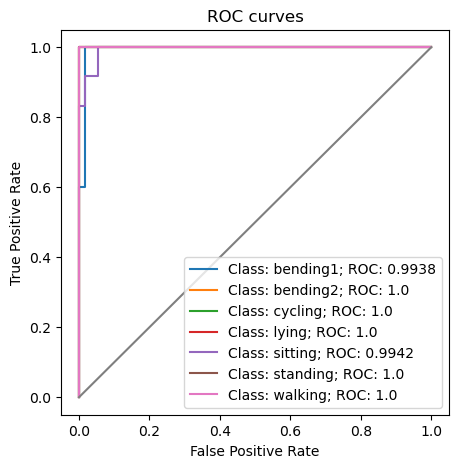

test ROC


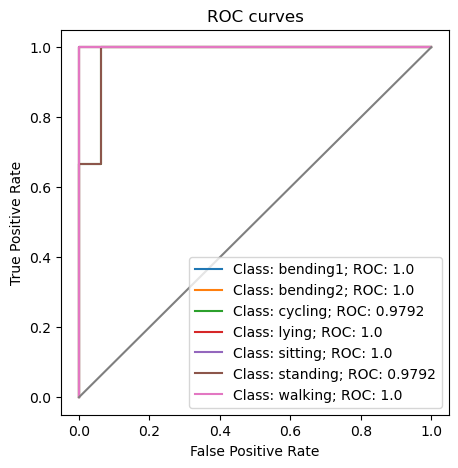

In [153]:

def logistic_regression_l1_multinomial_bestl(train_files, test_files, oversample=False):
 
    Xs = [] 
    l_val=2
    for i in range(1, 6*l_val+1):
        for stat in Order_Stats:
                Xs.append(f'{stat}{i}')        
    train_set = load_data(train_files, Xs, l_val)
#     train_set['label'] = train_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
        
    test_set = load_data(test_files, Xs, l_val)
#     test_set['label'] = test_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0) 
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

    model = LogisticRegression(
      
           penalty='l1', 
            max_iter=100,
            multi_class='multinomial',
         
            solver = 'saga'  
           
        )
    model.fit(trainX,trainY)
    train_proba = model.predict_proba(trainX)
    test_proba = model.predict_proba(testX)
    
    y_pred=model.predict(testX)
    cm = confusion_matrix(testY, y_pred)
    print(cm)
    
    print('train ROC')
    plot_roc_curve(trainY,train_proba,model)
    print('test ROC')
    plot_roc_curve(testY,test_proba,model)

logistic_regression_l1_multinomial_bestl(train_og, test)
   
      
      
       
    





#### ii. Naive Bayes

In [154]:

def NaiveBayes(train_files, test_files, oversample=False):
      
    for l_val in range(1,21):
        Xs = [] 
        for i in range(1, 6*l_val+1):
            for stat in Order_Stats:
                Xs.append(f'{stat}{i}')
        
        train_set = load_data(train_files, Xs, l_val)
#         train_set['label'] = train_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
        
        test_set = load_data(test_files, Xs, l_val)
#         test_set['label'] = test_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
        
        
        
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
      
        
        model = GaussianNB()
        
        model.fit(trainX, trainY)
        train_score = model.score(trainX, trainY)

        test_score = model.score(testX, testY)
        print(f' L: {l_val}  train_score: {train_score} test_score: {test_score}')
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            print('\n')
            print(f'The max accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
            
          
max_test_accuracy = 0
optimal_L = 1 
NaiveBayes(train_og, test)




 L: 1  train_score: 1.0 test_score: 0.8947368421052632
 L: 2  train_score: 1.0 test_score: 0.631578947368421
 L: 3  train_score: 0.9855072463768116 test_score: 0.7368421052631579
 L: 4  train_score: 1.0 test_score: 0.7894736842105263
 L: 5  train_score: 0.9855072463768116 test_score: 0.7894736842105263
 L: 6  train_score: 0.9710144927536232 test_score: 0.631578947368421
 L: 7  train_score: 1.0 test_score: 0.7368421052631579
 L: 8  train_score: 0.9855072463768116 test_score: 0.7368421052631579
 L: 9  train_score: 1.0 test_score: 0.6842105263157895
 L: 10  train_score: 1.0 test_score: 0.7894736842105263
 L: 11  train_score: 0.9855072463768116 test_score: 0.6842105263157895
 L: 12  train_score: 1.0 test_score: 0.631578947368421
 L: 13  train_score: 1.0 test_score: 0.7368421052631579
 L: 14  train_score: 1.0 test_score: 0.5789473684210527
 L: 15  train_score: 1.0 test_score: 0.5789473684210527
 L: 16  train_score: 1.0 test_score: 0.5263157894736842
 L: 17  train_score: 1.0 test_score: 0.52

1
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
train ROC


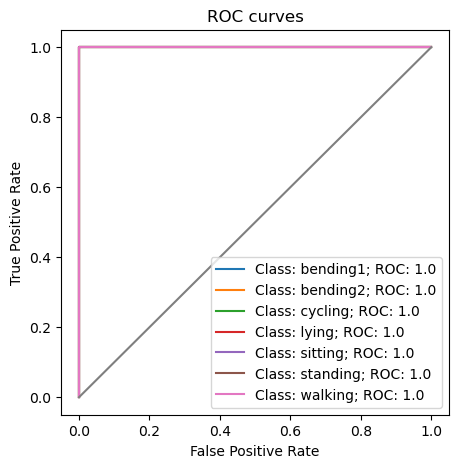

test ROC


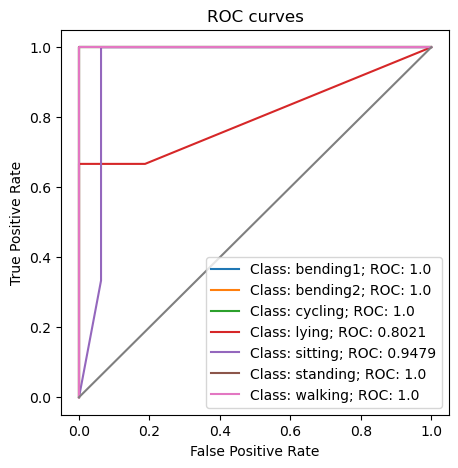

In [155]:

def  NaiveBayes_Best(train_files, test_files, oversample=False):
 
    Xs = [] 
    l_val=optimal_L
    print(l_val)
    for i in range(1, 6*l_val+1):
        for stat in Order_Stats:
                Xs.append(f'{stat}{i}')        
    train_set = load_data(train_files, Xs, l_val)
#     train_set['label'] = train_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)   
        
    test_set = load_data(test_files, Xs, l_val)
#     test_set['label'] = test_set['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0) 
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

    model = GaussianNB()
    model.fit(trainX,trainY)
    train_proba = model.predict_proba(trainX)
    test_proba = model.predict_proba(testX)
    
    y_pred=model.predict(testX)
    cm = confusion_matrix(testY, y_pred)
    print(cm)
    
    print('train ROC')
    plot_roc_curve(trainY,train_proba,model)
    print('test ROC')
    plot_roc_curve(testY,test_proba,model)
NaiveBayes_Best(train_og, test)
   
      
      
       
    





#### iii. Comparison

 I would say that Logistic Regression has better classification for the given dataset. since it gave accuracy of 1. multinomial gave best test score :0.9473684210526315 and naive bayes gave: 0.8947368421052632.
 Implementation wise, as we are only changing the function , all three seemed the same to name me.